In [1]:
import tensorflow as tf
from tensorflow.keras import layers, optimizers, losses, Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

from joblib import Parallel, delayed
import joblib

import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.stats import f_oneway
from scipy import stats

from sklearn.model_selection import KFold, train_test_split

import time

In [2]:
# TODO
# Write the functions for the optimizers
# import and create all the data sets
# find a way to get optimal number of hidden units
# find a way to get the parameter values
# write a proper report

# Training

## 1. Stochastic Gradient Descent

In [3]:
@tf.function()
def train_step(x, y, model, loss_fn, learning_rate, momentum, velocity):
    with tf.GradientTape() as tape:
        output = model(x)
        loss_value = loss_fn(y, output)
    grads = tape.gradient(loss_value, model.trainable_weights)

    for i, grad in enumerate(grads):
        velocity[i].assign(momentum * velocity[i] - learning_rate * grad)

    for i, var in enumerate(model.trainable_weights):
        var.assign_add(velocity[i])
    
    return loss_value

@tf.function()
def test_step(x, y, model, loss_fn):
    output = model(x)
    loss_value = loss_fn(y, output)
    return loss_value
    #test_output = model(x, training=False)

def train_model_SGD(
        model: tf.keras.Model, 
        loss_fn: tf.keras.losses,
        X: np.array, 
        y: np.array, 
        learning_rate: float,
        momentum: float=0.9,
        X_val: np.array=None, 
        y_val: np.array=None,
        patience=10,
        epochs=100,
        verbose=1,
        batch_size=256) -> tf.keras.Model:
    '''
    Implements Stochastic Gradient Descent with 
    batch size 64, with a 100 epochs.
    X_val and y_val is used for early stopping.

    Return: trained model.
    '''
    losses = []
    val_losses = []
    total_time = 0
    train_ds = tf.data.Dataset.from_tensor_slices((X, y))
    train_ds = train_ds.shuffle(buffer_size=X.shape[0], seed = 1)
    train_ds = train_ds.batch(batch_size)
    train_ds = train_ds.prefetch(batch_size)

    if X_val is not None and y_val is not None:
        test_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
        test_ds = test_ds.batch(batch_size)
        test_ds = test_ds.prefetch(batch_size)

    # initialize the velocity for each trainable weight
    velocity = [tf.Variable(tf.zeros_like(var)) for var in model.trainable_weights]

    best_val_loss = np.Inf
    patience_counter = 0
    for epoch in range(epochs):
        if verbose == 1:
            print(f'\nStart of epoch {epoch}')
        start_time = time.time()

        num_batches = 0
        total_train_loss = 0
        for step, (x_batch_train, y_batch_train) in enumerate(train_ds):
            loss_value = train_step(
                x_batch_train, y_batch_train, model, loss_fn, learning_rate, momentum, velocity
            )
            total_train_loss += loss_value.numpy()
            num_batches += 1

        avg_train_loss = total_train_loss / num_batches
        if verbose == 1:
            print(f'Training loss: {avg_train_loss}')
        
        if verbose == 2:
            losses.append(avg_train_loss)

        if X_val is not None and y_val is not None:
            total_val_loss = 0.0
            num_batches = 0
            for x_batch_val, y_batch_val in test_ds:
                val_loss = test_step(x_batch_val, y_batch_val, model, loss_fn)
                total_val_loss += val_loss.numpy()
                num_batches += 1
            avg_val_loss = total_val_loss / num_batches
            if verbose == 1:
                print(f'Val loss: {avg_val_loss}')
            if verbose == 2:
                val_losses.append(avg_val_loss)

            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                patience_counter = 0
            else:
                patience_counter += 1
            
            if patience_counter >= patience:
                if verbose == 1:
                    print(f'Early stopping at epoch {epoch}')
                break
        
        if verbose == 1:
            print("Time taken: %.2fs" % (time.time() - start_time))
            
        total_time += time.time() - start_time
    
    if verbose == 2:
        return model, losses, val_losses, total_time
    
    return model

## 2. Scaled Conjugate Gradient

In [4]:
#@tf.function
def train_step1(x, y, model, loss_fn, lambda_, sigma, lambda_mean, k, N, p_k, r_k, success, delta_k, sigma_k, new_model):

    def calculate_norm(weights):
        flattened_weights = [tf.reshape(w, [-1]) for w in weights]
        concatenated_weights = tf.concat(flattened_weights, axis=0)
        return tf.norm(concatenated_weights)
    
    with tf.GradientTape() as tape:
        output = model(x)
        loss_value = loss_fn(y, output)

    grads = tape.gradient(loss_value, model.trainable_weights)

    p_k_norm = calculate_norm(p_k)
    stop = False
    # step 2
    if success:

        # calculate the second order information
        sigma_k = sigma / p_k_norm
        
        # calculate sk
        new_model = tf.keras.models.clone_model(model)
        new_model.set_weights(model.get_weights())
        
        with tf.GradientTape() as tape: # calculate derivative at new point
           for i, var in enumerate(new_model.trainable_weights):
                var.assign_add(sigma_k*p_k[i])
           new_output = new_model(x)
           new_loss_value = loss_fn(y, new_output)
        new_grads = tape.gradient(new_loss_value, new_model.trainable_weights)
        
        # calculating delta k
        s_k = [(new_grads[i] - grads[i]) / sigma_k for i in range(len(grads))]

        delta_k = sum([tf.reduce_sum(tf.multiply(p_k[i], s_k[i])) for i in range(len(grads))])

    # step 3
    delta_k = delta_k + (lambda_ - lambda_mean) * p_k_norm**2

    # step 4
    if delta_k <= 0:
        
        # make the hessian matrix postive definite'
        lambda_mean = 2*(lambda_mean - delta_k / p_k_norm**2)
        delta_k = -delta_k + lambda_*p_k_norm**2 
        lambda_ = lambda_mean

    # step 5
    # Calculate the step size
    mu_k = sum([tf.reduce_sum(tf.multiply(p_k[i], r_k[i])) for i in range(len(grads))])
    alpha_k = mu_k / delta_k

    # step 6
    # calculate the comparison parameter
    new_model.set_weights(model.get_weights())
    with tf.GradientTape() as tape:
        for i, var in enumerate(new_model.trainable_weights):
            var.assign_add(alpha_k*p_k[i])
        new_output = new_model(x)
        new_loss_value = loss_fn(y, new_output)
    new_grads = tape.gradient(new_loss_value, new_model.trainable_weights)
    
    tri_k = 2*delta_k*(loss_value-new_loss_value)/mu_k**2

    # step 7
    if tri_k >= 0:
        
        # a successful reduction in the error can be made
        for i, var in enumerate(model.trainable_weights):
            var.assign_add(alpha_k*p_k[i])

        r_k1 = [-g for g in new_grads]
        lambda_mean = 0
        success = True

        if k % N == 0:
            # restart the algorithm
            p_k1 = r_k1
        
        else:
            ip = sum([tf.reduce_sum(tf.multiply(r_k1[i], r_k[i])) for i in range(len(grads))])
            b_k = (calculate_norm(r_k1)**2 -  ip) / mu_k
            p_k1 = [r_k1[i] + b_k*p_k[i] for i in range(len(p_k))]
        
        if tri_k >= 0.75:
            # reduce the scale paramater
            lambda_ = 0.25*lambda_
    
    else:
        lambda_mean = lambda_
        success = False
        p_k1 = p_k
        r_k1 = r_k

    if tri_k <= 0.25:
        # increase the scale parameter
        lambda_ = lambda_ + (delta_k*(1-tri_k) / p_k_norm**2)
    
    if calculate_norm(r_k) > 1e-10:
        
        k +=1
        p_k = p_k1
        r_k = r_k1
    
    else:
        stop = True

    return loss_value, r_k, p_k, k, lambda_, lambda_mean, N, success, stop, delta_k, sigma_k, new_model

#@tf.function()
def test_step1(x, y, model, loss_fn):
    output = model(x)
    loss_value = loss_fn(y, output)
    return loss_value

def train_model_SCG(
        model: tf.keras.Model, 
        loss_fn: tf.keras.losses,
        X: np.array, 
        y: np.array,
        X_val: np.array=None, 
        y_val: np.array=None,
        patience=10,
        epochs=100,
        verbose=1) -> tf.keras.Model:
    '''
    Implements Scaled Conjugate Gradient (SCG) optimisation with early stopping.
    The batch size is set to the full training data set for batch gradient descent.
    X_val and y_val is used for early stopping.

    Return: trained model.
    '''
    losses = []
    val_losses = []
    total_time = 0
    batch_size = len(X)
    train_ds = tf.data.Dataset.from_tensor_slices((X, y))
    train_ds = train_ds.shuffle(buffer_size=X.shape[0], seed = 1)
    train_ds = train_ds.batch(batch_size)
    train_ds = train_ds.prefetch(batch_size)

    if X_val is not None and y_val is not None:
        test_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
        test_ds = test_ds.batch(batch_size)
        test_ds = test_ds.prefetch(batch_size)

    #intialise the required variables
    lambda_= 1e-6
    sigma = 1e-4               
    lambda_mean = 0.0
    k = 1

    trainable_weights = model.trainable_weights
    N = sum([tf.size(w).numpy() for w in trainable_weights])

    best_val_loss = np.Inf
    patience_counter = 0

    # step 1 initialise parameters
    _ = 0
    for x_batch_train, y_batch_train in train_ds:
        with tf.GradientTape() as tape:
            output = model(x_batch_train)
            loss_value = loss_fn(y_batch_train, output)

        grads = tape.gradient(loss_value, model.trainable_weights)
        p_k = [-g for g in grads]

        r_k = [-g for g in grads]
        k = 1
        delta_k = None
        success = True
        sigma_k = None
        new_model = None
        _ += 1

    if _ > 1:
        print('Error: not batch algorithm')
        return None

    for epoch in range(epochs):
        if verbose == 1:
            print(f'\nStart of epoch {epoch}')
        start_time = time.time()

        num_batches = 0
        total_train_loss = 0
        for step, (x_batch_train, y_batch_train) in enumerate(train_ds):
            loss_value, r_k, p_k, k, lambda_, lambda_mean, N, success, stop, delta_k, sigma_k, new_model = \
            train_step1(
                x_batch_train, y_batch_train, model, loss_fn, lambda_, sigma, lambda_mean, \
                    k, N, p_k, r_k, success, delta_k, sigma_k, new_model
            )
            total_train_loss += loss_value
            num_batches += 1
            
            if stop:
                # algorithm converged
                break

        avg_train_loss = total_train_loss.numpy() / num_batches
        if verbose == 1:
            print(f'Training loss: {avg_train_loss}')
        if verbose == 2:
            losses.append(avg_train_loss)
        # if X_val is None and y_val is None and avg_train_loss < tol:
        #     print('Converged at epoch {epoch}')

        if X_val is not None and y_val is not None:
            total_val_loss = 0.0
            num_batches = 0
            for x_batch_val, y_batch_val in test_ds:
                val_loss = test_step1(x_batch_val, y_batch_val, model, loss_fn)
                total_val_loss += val_loss.numpy()
                num_batches += 1

            avg_val_loss = total_val_loss / num_batches
            if verbose == 1:
                print(f'Val loss: {avg_val_loss}')
            
            if verbose == 2:
                val_losses.append(avg_val_loss)

            # if avg_val_loss < tol:
            #     print(f'Validation loss converged at epoch {epoch}')

            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                patience_counter = 0
            else:
                patience_counter += 1
            
            if patience_counter >= patience:
                if verbose == 1:
                 print(f'Early stopping at epoch {epoch}')
                break
        
        if verbose == 1:
            print("Time taken: %.2fs" % (time.time() - start_time))
        total_time += time.time() - start_time

    if verbose == 2:
        return model, losses, val_losses, total_time
    
    return model

## 3. Leap-Frog (b)

In [6]:
def calculate_norm(weights):
    flattened_weights = [tf.reshape(w, [-1]) for w in weights]
    concatenated_weights = tf.concat(flattened_weights, axis=0)
    return tf.norm(concatenated_weights)

#@tf.function
def train_step2(x, y, model, loss_fn, tri_t, delta, m, delta1, epsilon, i, j, s, p, k, a_k, v_k, v_k1,\
                prev_v, prev_weights, current_weights, next_weights, next_next_weights, a_k1, go_to_6):

    stop = False
    if not go_to_6:

        stop = False
        go_to_five_b = False

        # step 3
        k += 1
        prev_v = v_k[:]
        v_k = v_k1[:]
        a_k = a_k1[:]
        prev_weights = current_weights[:]
        current_weights = next_weights[:]
        next_weights = next_next_weights[:]

        norm_v_k = calculate_norm(v_k)
        norm_tri_x_k = norm_v_k * tri_t

        # step 4
        if norm_tri_x_k < delta:
            pass # go to 5a

        else:
            v_k = [v_k[i]*delta / (tri_t*norm_v_k) for i in range(len(v_k))]
            go_to_five_b = True # go to 5b
        
        # step 5 a
        if not go_to_five_b:
            p += delta1
            tri_t *= p

        # step 5 b
        if s < m:
            pass # go to 5

        else:
            tri_t /= 2.
            current_weights = [(current_weights[i] + prev_weights[i]) / 2 for i in range(len(current_weights))]
            v_k = [(v_k[i] + prev_v[i]) / 4. for i in range(len(v_k))]
            s = 0

        # step 5
        next_weights = [current_weights[i] + v_k[i]*tri_t for i in range(len(v_k))]

    # step 6
    model.set_weights(next_weights)
    with tf.GradientTape() as tape:
        output = model(x)
        loss_value = loss_fn(y, output)
    

    a_k1 = [-g for g in tape.gradient(loss_value, model.trainable_weights)]
    v_k1 = [v_k[i] + a_k1[i]*tri_t for i in range(len(v_k))]

    # step 7a
    a_prod = np.sum([tf.reduce_sum(tf.multiply(a_k1[i], a_k[i])) for i in range(len(a_k))])
    if a_prod > 0:
        s = 0
    else:
        s += 1
        p = 1.
    
    # step 7:
    if calculate_norm(a_k1) < epsilon:

        stop = True
        return loss_value, i, j, s, p, k, a_k, v_k, v_k1, prev_v, prev_weights, current_weights, \
            next_weights, next_next_weights, a_k1, stop, go_to_6

    # step 8:
    if calculate_norm(v_k1) > calculate_norm(v_k):
        i = 0
        # go to step 3
        go_to_6 = False
        return loss_value, i, j, s, p, k, a_k, v_k, v_k1, prev_v, prev_weights, current_weights, \
            next_weights, next_next_weights, a_k1, stop, go_to_6

    else:
        next_next_weights = [(v1+v2)/2 for v1, v2 in zip(next_weights, current_weights)]
        i += 1
    
    # step 9
    if i <= j:
        v_k1 = [(v_k1[i] + v_k[i]) / 4 for i in range(len(v_k))]

        k += 1
        prev_v = v_k[:]
        v_k = v_k1[:]
        a_k = a_k1[:]
        prev_weights = current_weights[:]
        current_weights = next_weights[:]
        next_weights = next_next_weights[:]
        # go to 6
    
    else:
        v_k1 = [v*0. for v in v_k1]
        j = 1

        k += 1
        prev_v = v_k[:]
        v_k = v_k1[:]
        a_k = a_k1[:]
        prev_weights = current_weights[:]
        current_weights = next_weights[:]
        next_weights = next_next_weights[:]
        # go to 6
    
    go_to_6 = True
    return loss_value, i, j, s, p, k, a_k, v_k, v_k1, prev_v, prev_weights, current_weights, \
            next_weights, next_next_weights, a_k1, stop, go_to_6

#@tf.function()
def test_step2(x, y, model, loss_fn):
    output = model(x)
    loss_value = loss_fn(y, output)
    return loss_value

def train_model_LF(
        model: tf.keras.Model, 
        loss_fn: tf.keras.losses,
        X: np.array, 
        y: np.array,
        tri_t = 0.5,
        delta: np.float_ = 1,
        m: np.int_= 3,
        delta1: np.float_ = 0.001,
        epsilon: np.float_ = 1e-6,
        X_val: np.array=None, 
        y_val: np.array=None,
        patience=10,
        epochs=100,
        verbose=1) -> tf.keras.Model:
    '''
    Implements Leap Frog (LF) optimisation with early stopping.
    The batch size is set to the full training data set for batch gradient descent.
    X_val and y_val is used for early stopping.

    Return: trained model.
    '''
    losses = []
    val_losses = []
    total_time = 0
    batch_size = len(X)
    train_ds = tf.data.Dataset.from_tensor_slices((X, y))
    train_ds = train_ds.shuffle(buffer_size=X.shape[0], seed = 1)
    train_ds = train_ds.batch(batch_size)
    train_ds = train_ds.prefetch(batch_size)

    if X_val is not None and y_val is not None:
        test_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
        test_ds = test_ds.batch(batch_size)
        test_ds = test_ds.prefetch(batch_size)


    trainable_weights = model.trainable_weights
    N = sum([tf.size(w).numpy() for w in trainable_weights])

    best_val_loss = np.Inf
    patience_counter = 0

    # step 1
    # set initial values
    i, j, s, p, k = 0, 2, 0., 1., -1

    # step 2
    _ = 0
    for step, (x_batch_train, y_batch_train) in enumerate(train_ds):
        with tf.GradientTape() as tape:
            outputs = model(x_batch_train)
            loss_value = loss_fn(y, outputs)
        a_k = [-g for g in tape.gradient(loss_value, model.trainable_weights)]
        _ += 1
    
    if _ > 1:
        print('Not a batch algorithm')
    
    #np.sqrt(delta / 5. / calculate_norm(a_k))
    v_k = [0.5*tri_t*grad for grad in a_k]
    prev_v = v_k[:]
    v_k1 = v_k[:]
    prev_weights = model.get_weights()
    current_weights = model.get_weights()
    next_weights = model.get_weights()
    next_next_weights = model.get_weights()
    a_k1 = a_k[:]

    go_to_6 = False

    for epoch in range(epochs):
        if verbose == 1:
            print(f'\nStart of epoch {epoch}')
        start_time = time.time()

        num_batches = 0
        total_train_loss = 0
        for step, (x_batch_train, y_batch_train) in enumerate(train_ds):
            loss_value, i, j, s, p, k, a_k, v_k, v_k1, prev_v, prev_weights, \
                current_weights, next_weights, next_next_weights, a_k1, stop, go_to_6 = train_step2(
                x_batch_train, y_batch_train, model, loss_fn, tri_t, delta, m, delta1, epsilon, \
                i, j, s, p, k, a_k, v_k, v_k1, prev_v, prev_weights, current_weights, next_weights, next_next_weights, a_k1, go_to_6)
            total_train_loss += loss_value
            num_batches += 1
            
        if stop:
            break

        avg_train_loss = total_train_loss.numpy() / num_batches
        if verbose == 1:
            print(f'Training loss: {avg_train_loss}')
        
        if verbose == 2:
            losses.append(avg_train_loss)
        
        # if X_val is None and y_val is None and avg_train_loss < tol:
        #     print('Converged at epoch {epoch}')

        if X_val is not None and y_val is not None:
            total_val_loss = 0.0
            num_batches = 0
            for x_batch_val, y_batch_val in test_ds:
                val_loss = test_step2(x_batch_val, y_batch_val, model, loss_fn)
                total_val_loss += val_loss.numpy()
                num_batches += 1

            avg_val_loss = total_val_loss / num_batches
            if verbose == 1:
                print(f'Val loss: {avg_val_loss}')

            if verbose == 2:
                val_losses.append(avg_val_loss)

            # if avg_val_loss < tol:
            #     print(f'Validation loss converged at epoch {epoch}')

            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                patience_counter = 0
            else:
                patience_counter += 1
            
            if patience_counter >= patience:
                if verbose == 1:
                    print(f'Early stopping at epoch {epoch}')
                break
        if verbose == 1:
            print("Time taken: %.2fs" % (time.time() - start_time))

        total_time += time.time() - start_time
    
    if verbose == 2:
        return model, losses, val_losses, total_time
    
    return model

# Function 1

In [7]:
df1 = pd.read_csv('Function1.csv', index_col=0)
df1.head()

,x,y,z
0,-1.861037,9.111182,12.574642
1,1.161023,3.054261,4.402236
2,3.609072,0.129403,13.154805
3,-3.591472,3.239865,16.138535
4,8.557571,1.779436,75.011460


In [8]:
X = df1.drop('z', axis=1).values
y = df1['z'].values

In [9]:
def scale_inputs(X):
    return 2*(X - np.min(X, axis=0)) / (np.max(X, axis=0) - np.min(X, axis=0) + 10e-5) - 1

In [10]:
class MinMaxScaler():
    def __init__(self):
        pass
    def fit_transform(self, X):
        self.Xmin, self.Xmax = np.min(X, axis=0), np.max(X, axis=0)
        return 2*(X - np.min(X, axis=0)) / (np.max(X, axis=0) - np.min(X, axis=0) + 10e-5) - 1
    def transform(self, X):
        return 2*(X - self.Xmin) / (self.Xmax - self.Xmin + 10e-5) - 1

In [11]:
def _make_model(hidden_units, learning_rate) -> tf.keras.Model:
    model = Sequential([
        layers.Input(shape=(2,)),
        layers.Dense(hidden_units, activation='tanh'),
        layers.Dense(1)
    ])
    model.compile(loss='MeanSquaredError', optimizer=optimizers.Adam(learning_rate=learning_rate))
    return model

In [12]:
adam_learning_rates = [0.0001, 0.001, 0.01, 0.1, 0.2]
mms = MinMaxScaler()

def _evaulate_splits(X, y, train_index, val_index, lr, number_of_hidden_units):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    X_train = mms.fit_transform(X_train)
    X_val = mms.transform(X_val)

    y_train = mms.fit_transform(y_train)
    y_val = mms.transform(y_val)

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model = _make_model(number_of_hidden_units, lr)
    model.fit(
        X_train, 
        y_train, 
        validation_data=(X_val, y_val),
        batch_size=256, 
        epochs=100,
        verbose=0,
        callbacks=early_stopping)
    
    val_loss = model.evaluate(X_val, y_val, verbose=0)
    return val_loss

def learning_rate_cross_val(X, y, number_of_hidden_units):
    kf = KFold(n_splits=5)
    best_lr = None
    best_fold_losses = None
    best_fold_averages = np.Inf

    for lr in adam_learning_rates:
        print(f'Learning rate {lr}')
        fold_losses = []

        fold_losses = Parallel(n_jobs=4)(delayed(_evaulate_splits)(
            X, y, train_index, val_index, lr, number_of_hidden_units) for train_index, val_index in kf.split(X))
    
        avg_score = np.mean(fold_losses)
        print(avg_score)
        if avg_score < best_fold_averages:
            best_fold_averages = avg_score
            best_fold_losses = fold_losses
            best_lr = lr
    
    return best_lr, best_fold_averages, best_fold_losses


# def estimate_number_of_hidden_units_regression(X, y):
number_of_hidden_units = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
if not os.path.exists('function1_nhu_resutls.joblib'):

    np.random.seed(123)

    
    best_learning_rates = []
    best_folds_losses = []
    best_averages = []

    for nhu in number_of_hidden_units:
        print('Processing number of hidden units', nhu)
        best_lr, best_ave, best_losses = learning_rate_cross_val(X, y, nhu)
        best_learning_rates.append(best_lr)
        best_folds_losses.append(best_losses)
        best_averages.append(best_ave)
    
    function1_nhu_resutls = {'best_learning_rates':best_learning_rates,
    'best_folds_losses':best_folds_losses,
    'best_averages':best_averages}
    joblib.dump(function1_nhu_resutls, 'function1_nhu_resutls.joblib')

else:
    best_learning_rates, best_folds_losses, best_averages = joblib.load('function1_nhu_resutls.joblib').values()

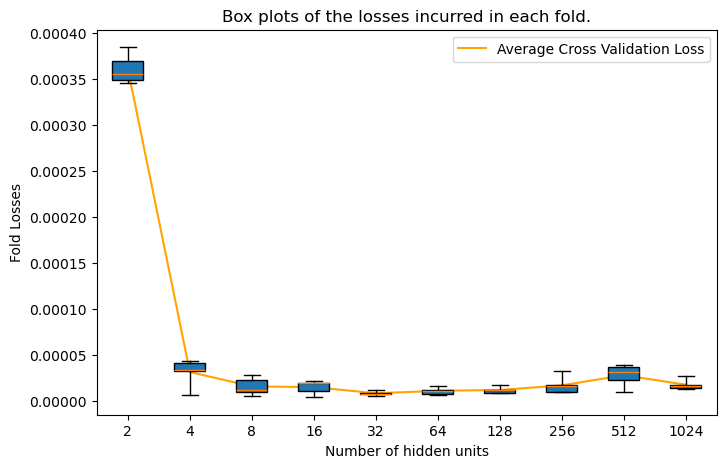

In [13]:
plt.figure(figsize=(8, 5))
plt.boxplot(best_folds_losses, vert=True, patch_artist=True, whis=[0, 100], zorder=2)
plt.xticks(range(1, len(number_of_hidden_units)+1), list(map(str, number_of_hidden_units)))
plt.plot(range(1, len(number_of_hidden_units)+1), best_averages, color='orange', zorder=1, label='Average Cross Validation Loss')
plt.title('Box plots of the losses incurred in each fold.')
plt.xlabel('Number of hidden units')
plt.ylabel('Fold Losses')
plt.legend()
plt.show()

From the boxplot it appears that the number of hidden units 8, 16, 32, 64, 128 performs the best. To determine whether these cross validation scores are different the ANOVA test will be used.

In [14]:
f_stat, p_value = f_oneway(best_folds_losses[2], best_folds_losses[3], best_folds_losses[4], best_folds_losses[5], best_folds_losses[6])

print(f"F-statistic: {f_stat}")
print(f"P-value: {p_value}")

F-statistic: 1.2970434079804711
P-value: 0.3048044798750365


Since there is no statistical difference between these cross validation scores, the optimal number of hidden units chosen are 8, according to the principle of Occam's Razor.

### Parameter tuning for Stochastic Gradient Descent

In [15]:
function_1_fold_losses = []

In [16]:
param_grid = {
    'momentum': [0.0, 0.5, 0.9, 0.99],
    'learning_rate': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]
}
mms = MinMaxScaler()

def _evaulate_splits(X, y, train_index, val_index, learning_rate, momentum):

    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    X_train = mms.fit_transform(X_train)
    X_val = mms.transform(X_val)

    y_train = mms.fit_transform(y_train)
    y_val = mms.transform(y_val)


    model = Sequential([
        layers.Input(shape=(2,)),
        layers.Dense(8, activation='tanh'),
        layers.Dense(1)
    ])
    loss_fn = losses.MeanSquaredError()
    model = train_model_SGD(
        model, 
        loss_fn, 
        X_train, 
        y_train, 
        learning_rate=learning_rate, 
        momentum=momentum, 
        X_val=X_val, 
        y_val=y_val,
        epochs=100,
        verbose=0)

    y_pred = model(X_val, training=False)
    val_loss = loss_fn(y_val, y_pred)
    return val_loss.numpy()

def hp_cross_val(X, y):
    kf = KFold(n_splits=5)
    best_learning_rate = None
    best_momentum = None
    best_fold_losses = None
    best_fold_averages = np.Inf

    for learning_rate in param_grid['learning_rate']:
        for momentum in param_grid['momentum']:
            print(f'Learning rate {learning_rate}')
            fold_losses = []

            fold_losses = Parallel(n_jobs=5)(delayed(_evaulate_splits)(
                X, y, train_index, val_index, learning_rate, momentum) for train_index, val_index in kf.split(X))
        
            avg_score = np.mean(fold_losses)
            print(avg_score)

            if avg_score < best_fold_averages:
                best_momentum = momentum
                best_learning_rate = learning_rate
                best_fold_averages = avg_score
                best_fold_losses = fold_losses
    
    return best_learning_rate, best_momentum, best_fold_losses, best_fold_averages


if not os.path.exists('function1_SGD_resutls.joblib'):

    np.random.seed(123)
    best_learning_rate, best_momentum, fold_scores, cross_val_score = hp_cross_val(X, y)
    
    function1_SGD_resutls = {
        'best_learning_rate': best_learning_rate,
        'best_momentum': best_momentum,
        'best_folds_losses': fold_scores,
        'best_cv_score':cross_val_score
    }
    joblib.dump(function1_SGD_resutls, 'function1_SGD_resutls.joblib')

else:
    best_learning_rate, best_momentum, best_folds_losses, best_cv_score = joblib.load('function1_SGD_resutls.joblib').values()
        

In [17]:
print(best_learning_rate, best_momentum, best_folds_losses, best_cv_score)

0.05 0.99 [3.8927874e-06, 1.933491e-05, 6.0624e-06, 1.7131731e-06, 4.8370853e-06] 7.168071e-06


In [18]:
function_1_fold_losses.append(best_folds_losses)

In [19]:
# scaled conjugate
param_grid = {
    'None': [None]
}
mms = MinMaxScaler()

def _evaulate_splits(X, y, train_index, val_index):

    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    X_train = mms.fit_transform(X_train)
    X_val = mms.transform(X_val)

    y_train = mms.fit_transform(y_train)
    y_val = mms.transform(y_val)


    model = Sequential([
        layers.Input(shape=(2,)),
        layers.Dense(8, activation='tanh'),
        layers.Dense(1)
    ])
    loss_fn = losses.MeanSquaredError()
    model = train_model_SCG(
        model, 
        loss_fn, 
        X_train, 
        y_train,
        X_val=X_val, 
        y_val=y_val,
        epochs=500,
        verbose=0)

    y_pred = model(X_val, training=False)
    val_loss = loss_fn(y_val, y_pred)
    return val_loss.numpy()

def hp_cross_val(X, y):
    kf = KFold(n_splits=5)


    fold_losses = []

    fold_losses = Parallel(n_jobs=5)(delayed(_evaulate_splits)(
        X, y, train_index, val_index) for train_index, val_index in kf.split(X))

    avg_score = np.mean(fold_losses)
    print(avg_score)

    best_fold_averages = avg_score
    best_fold_losses = fold_losses
    
    return best_fold_losses, best_fold_averages


if not os.path.exists('function1_SCG_resutls.joblib'):

    np.random.seed(123)
    fold_scores, cross_val_score = hp_cross_val(X, y)
    
    function1_SCG_resutls = {
        'best_folds_losses': fold_scores,
        'best_cv_score':cross_val_score
    }
    joblib.dump(function1_SCG_resutls, 'function1_SCG_resutls.joblib')

else:
    best_folds_losses, best_cv_score = joblib.load('function1_SCG_resutls.joblib').values()
        

In [20]:
print(best_folds_losses, best_cv_score)

[1.3364595e-05, 2.037616e-06, 1.347357e-06, 8.188678e-06, 1.1105128e-06] 5.209752e-06


In [21]:
function_1_fold_losses.append(best_folds_losses)

In [22]:
# learp frog
param_grid = {
    'tri_t': [0.01, 0.1, 0.5],
    'm': [3],
    'delta1': [0.001, 0.01],
}
mms = MinMaxScaler()

def _evaulate_splits(X, y, train_index, val_index, tri_t, m, delta1):

    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    X_train = mms.fit_transform(X_train)
    X_val = mms.transform(X_val)

    y_train = mms.fit_transform(y_train)
    y_val = mms.transform(y_val)

    model = Sequential([
        layers.Input(shape=(2,)),
        layers.Dense(8, activation='tanh'),
        layers.Dense(1)
    ])
    loss_fn = losses.MeanSquaredError()
    model = train_model_LF(
        model, 
        loss_fn, 
        X_train, 
        y_train,
        tri_t=tri_t,
        delta=1,
        epsilon=1e-6,
        m=m,
        delta1=delta1,
        X_val=X_val, 
        y_val=y_val, 
        epochs=500,
        patience=50,
    )

    y_pred = model(X_val, training=False)
    val_loss = loss_fn(y_val, y_pred)
    return val_loss.numpy()

def hp_cross_val(X, y):
    kf = KFold(n_splits=5)
    best_tri_t = None
    best_delta1 = None
    best_m = None
    best_fold_losses = None
    best_fold_averages = np.Inf

    for tri_t in param_grid['tri_t']:
        for delta1 in param_grid['delta1']:
            for m in param_grid['m']:
                print(tri_t, delta1, m)
                fold_losses = []

                fold_losses = Parallel(n_jobs=5)(delayed(_evaulate_splits)(
                    X, y, train_index, val_index, tri_t, m, delta1) for train_index, val_index in kf.split(X))
            
                avg_score = np.mean(fold_losses)
                print(avg_score)

                if avg_score < best_fold_averages:
                    best_tri_t= tri_t
                    best_delta1 = delta1
                    best_m = m
                    best_fold_averages = avg_score
                    best_fold_losses = fold_losses
    
    return best_tri_t, best_delta1, best_m, best_fold_losses, best_fold_averages


if not os.path.exists('function1_LF_results.joblib'):

    np.random.seed(123)
    best_tri_t, best_delta1, best_m, fold_scores, cross_val_score = hp_cross_val(X, y)
    
    function1_LF_results = {
        'best_tri_t': best_tri_t,
        'best_delta1': best_delta1,
        'best_m': best_m,
        'best_folds_losses': fold_scores,
        'best_cv_score':cross_val_score
    }
    joblib.dump(function1_LF_results, 'function1_LF_results.joblib')

else:
    best_tri_t, best_delta1, best_m, best_folds_losses, best_cv_score = joblib.load('function1_LF_results.joblib').values()
        

In [23]:
print(best_tri_t, best_delta1, best_m, best_folds_losses, best_cv_score)

0.5 0.01 3 [2.7451977e-05, 1.451692e-05, 2.0801306e-06, 1.7400083e-05, 2.7409238e-05] 1.7771668e-05


In [24]:
function_1_fold_losses.append(best_folds_losses)

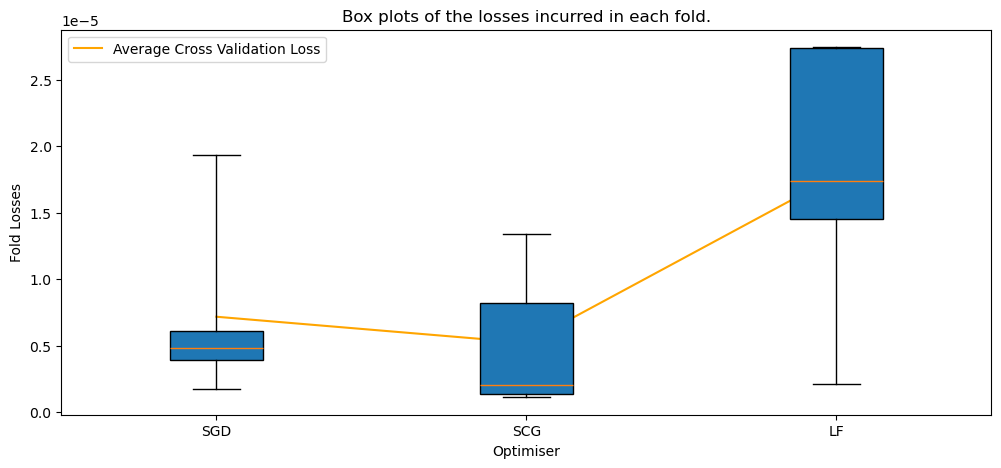

In [25]:
plt.figure(figsize=(12, 5))
plt.boxplot(function_1_fold_losses, vert=True, patch_artist=True, whis=[0, 100], zorder=2)
optimisers = ['SGD', 'SCG', 'LF']
plt.xticks(range(1, len(function_1_fold_losses)+1), list(map(str, optimisers)))
plt.plot(range(1, len(function_1_fold_losses)+1), [np.mean(x) for x in function_1_fold_losses], color='orange', zorder=1, label='Average Cross Validation Loss')
plt.title('Box plots of the losses incurred in each fold.')
plt.xlabel('Optimiser')
plt.ylabel('Fold Losses')
plt.legend()
plt.show()

Anova test to see if cross validation scores are the same.

In [26]:
f_stat, p_value = f_oneway(function_1_fold_losses[0], function_1_fold_losses[1], function_1_fold_losses[2])

print(f"F-statistic: {f_stat}")
print(f"P-value: {p_value}")

F-statistic: 3.62589039786151
P-value: 0.05864919126123152


In [27]:
stat, p_value = stats.levene(*function_1_fold_losses)

print(f"Levene's test statistic: {stat}\nP-value: {p_value}")

Levene's test statistic: 0.7274432494150357
P-value: 0.5032771873094593


No evidence that one optimiser is superior over another in solving this function.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

mms = MinMaxScaler()
X_train = mms.fit_transform(X_train)
X_test = mms.transform(X_test)

y_train = mms.fit_transform(y_train)
y_test = mms.transform(y_test)

In [28]:
np.random.seed(123)
model = Sequential([
    layers.Input(shape=(2,)),
    layers.Dense(8, activation='tanh'),
    layers.Dense(1)
])
loss_fn = losses.MeanSquaredError()
model, train_losses, val_losses, total_time = train_model_SGD(model, 
                                              loss_fn, 
                                              X_train, 
                                              y_train, 
                                              learning_rate=0.05, 
                                              momentum=0.99, 
                                              X_val=X_test, 
                                              y_val=y_test,
                                              verbose=2)

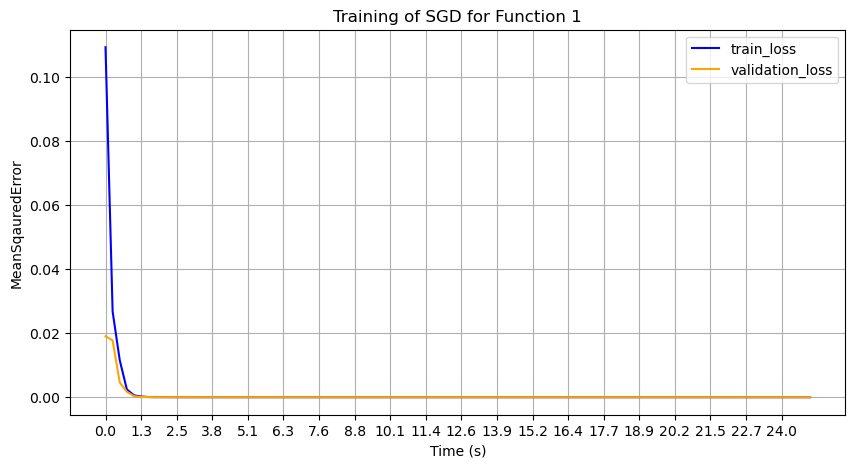

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, color='blue', label='train_loss')
plt.plot(val_losses, color='orange', label='validation_loss')
plt.xlabel('Time (s)')
plt.xticks(np.arange(0, len(train_losses), 5), np.round(np.arange(0, len(train_losses), 5) * total_time / len(train_losses), 1))
plt.ylabel('MeanSqauredError')
plt.title('Training of SGD for Function 1')
plt.grid()
plt.legend()
plt.show()

In [30]:
np.random.seed(123)
model = Sequential([
    layers.Input(shape=(2,)),
    layers.Dense(8, activation='tanh'),
    layers.Dense(1)
])
loss_fn = losses.MeanSquaredError()
model, train_losses, val_losses, total_time = train_model_SCG(
    model, 
    loss_fn, 
    X_train, 
    y_train, 
    X_val=X_test, 
    y_val=y_test, 
    epochs=500,
    verbose=2)

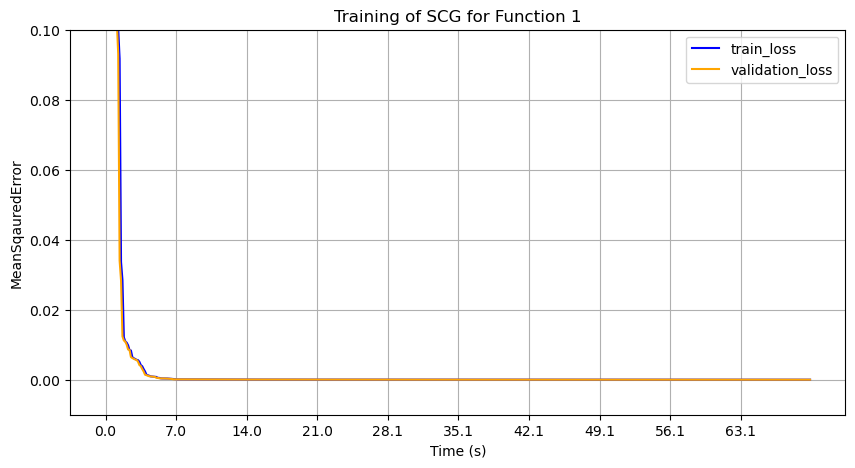

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, color='blue', label='train_loss')
plt.plot(val_losses, color='orange', label='validation_loss')
plt.xlabel('Time (s)')
plt.xticks(np.arange(0, len(train_losses), 50), np.round(np.arange(0, len(train_losses), 50) * total_time / len(train_losses), 1))
plt.ylabel('MeanSqauredError')
plt.title('Training of SCG for Function 1')
plt.ylim([-0.01, 0.1])
plt.grid()
plt.legend()
plt.show()

In [90]:
print(total_time)

70.40835475921631


In [34]:
np.random.seed(123)
model = Sequential([
    layers.Input(shape=(2,)),
    layers.Dense(8, activation='tanh'),
    layers.Dense(1)
])
loss_fn = losses.MeanSquaredError()
model, train_losses, val_losses, total_time = train_model_LF(model, 
        loss_fn, 
        X_train, 
        y_train,
        tri_t=0.5,
        delta=1,
        epsilon=1e-6,
        m=3,
        delta1=0.01,
        X_val=X_test, 
        y_val=y_test, 
        epochs=500,
        patience=50,
        verbose=2)

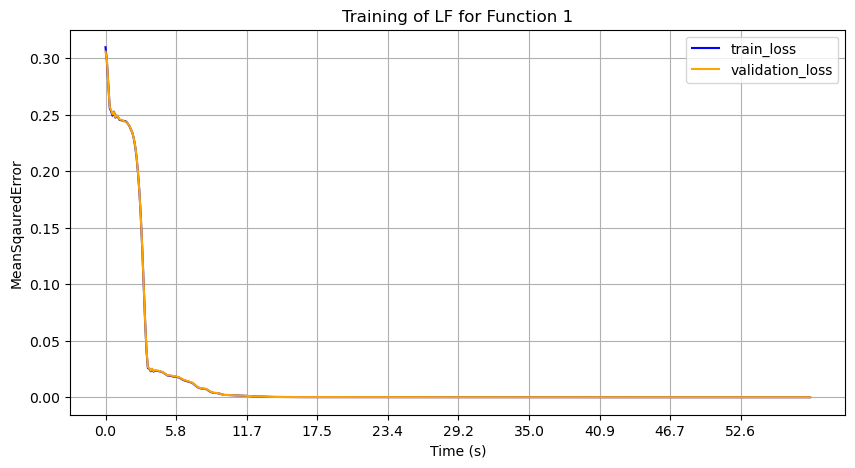

In [35]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, color='blue', label='train_loss')
plt.plot(val_losses, color='orange', label='validation_loss')
plt.xlabel('Time (s)')
plt.xticks(np.arange(0, len(train_losses), 50), np.round(np.arange(0, len(train_losses), 50) * total_time / len(train_losses), 1))
plt.ylabel('MeanSqauredError')
plt.title('Training of LF for Function 1')
plt.grid()
plt.legend()
plt.show()

In [36]:
total_time

58.40568280220032

# Function 2

In [28]:
df2 = pd.read_csv('Function2.csv', index_col=0)
df2.head()

,x,y,z
0,-7.921558,3.008260,2.791874e-02
1,-2.452249,-5.782716,6.574204e-03
2,-4.971099,7.153143,6.515884e-07
3,-2.333047,9.135583,3.688022e-04
4,-0.394208,-6.949539,3.617755e-01


In [29]:
X = df2.drop('z', axis=1).values
y = df2['z'].values

In [30]:
y.shape

(50000,)

In [31]:
number_of_hidden_units = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
if not os.path.exists('function2_nhu_resutls.joblib'):

    np.random.seed(123)

    best_learning_rates = []
    best_folds_losses = []
    best_averages = []

    for nhu in number_of_hidden_units:
        print('Processing number of hidden units', nhu)
        best_lr, best_ave, best_losses = learning_rate_cross_val(X, y, nhu)
        best_learning_rates.append(best_lr)
        best_folds_losses.append(best_losses)
        best_averages.append(best_ave)
    
    function2_nhu_resutls = {'best_learning_rates':best_learning_rates,
    'best_folds_losses':best_folds_losses,
    'best_averages':best_averages}
    joblib.dump(function2_nhu_resutls, 'function2_nhu_resutls.joblib')

else:
    best_learning_rates, best_folds_losses, best_averages = joblib.load('function2_nhu_resutls.joblib').values()

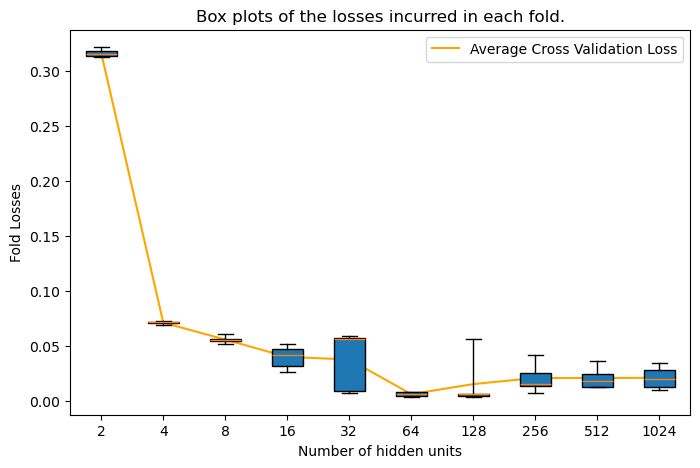

In [32]:
plt.figure(figsize=(8, 5))
plt.boxplot(best_folds_losses, vert=True, patch_artist=True, whis=[0, 100], zorder=2)
plt.xticks(range(1, len(number_of_hidden_units)+1), list(map(str, number_of_hidden_units)))
plt.plot(range(1, len(number_of_hidden_units)+1), best_averages, color='orange', zorder=1, label='Average Cross Validation Loss')
plt.title('Box plots of the losses incurred in each fold.')
plt.xlabel('Number of hidden units')
plt.ylabel('Fold Losses')
plt.legend()
plt.show()

The box plots of the cross validation losses of 64, 128, 256, 512, 1024 are the lowest. A ANOVA test will be conducted to see if there means are statistically different.

In [33]:
f_stat, p_value = f_oneway(best_folds_losses[5], best_folds_losses[6], best_folds_losses[7], best_folds_losses[8], best_folds_losses[9])

print(f"F-statistic: {f_stat}")
print(f"P-value: {p_value}")

F-statistic: 1.1300531770382116
P-value: 0.37059993903950567


Since the p-value is not statistically significant we deduce that the optimal number of hidden units is 64 by the principal of Occam's Razor.

In [34]:
function_2_fold_losses = []

In [35]:
param_grid = {
    'momentum': [0.0, 0.5, 0.9, 0.99],
    'learning_rate': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]
}
mms = MinMaxScaler()

def _evaulate_splits(X, y, train_index, val_index, learning_rate, momentum):

    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    X_train = mms.fit_transform(X_train)
    X_val = mms.transform(X_val)

    y_train = mms.fit_transform(y_train)
    y_val = mms.transform(y_val)


    model = Sequential([
        layers.Input(shape=(2,)),
        layers.Dense(64, activation='tanh'),
        layers.Dense(1)
    ])
    loss_fn = losses.MeanSquaredError()
    model = train_model_SGD(
        model, 
        loss_fn, 
        X_train, 
        y_train, 
        learning_rate=learning_rate, 
        momentum=momentum, 
        X_val=X_val, 
        y_val=y_val,
        epochs=100,
        verbose=0)

    y_pred = model(X_val, training=False)
    val_loss = loss_fn(y_val, y_pred)
    return val_loss.numpy()

def hp_cross_val(X, y):
    kf = KFold(n_splits=5)
    best_learning_rate = None
    best_momentum = None
    best_fold_losses = None
    best_fold_averages = np.Inf

    for learning_rate in param_grid['learning_rate']:
        for momentum in param_grid['momentum']:
            print(f'Learning rate {learning_rate}')
            fold_losses = []

            fold_losses = Parallel(n_jobs=5)(delayed(_evaulate_splits)(
                X, y, train_index, val_index, learning_rate, momentum) for train_index, val_index in kf.split(X))
        
            avg_score = np.mean(fold_losses)
            print(avg_score)

            if avg_score < best_fold_averages:
                best_momentum = momentum
                best_learning_rate = learning_rate
                best_fold_averages = avg_score
                best_fold_losses = fold_losses
    
    return best_learning_rate, best_momentum, best_fold_losses, best_fold_averages


if not os.path.exists('function2_SGD_resutls.joblib'):

    np.random.seed(123)
    best_learning_rate, best_momentum, fold_scores, cross_val_score = hp_cross_val(X, y)
    
    function2_SGD_resutls = {
        'best_learning_rate': best_learning_rate,
        'best_momentum': best_momentum,
        'best_folds_losses': fold_scores,
        'best_cv_score':cross_val_score
    }
    joblib.dump(function2_SGD_resutls, 'function2_SGD_resutls.joblib')

else:
    best_learning_rate, best_momentum, best_folds_losses, best_cv_score = joblib.load('function2_SGD_resutls.joblib').values()
        

In [36]:
print(best_learning_rate, best_momentum, best_folds_losses, best_cv_score)

0.01 0.99 [0.042620476, 0.06709447, 0.04613695, 0.046406053, 0.042291768] 0.04890994


In [37]:
function_2_fold_losses.append(best_folds_losses)

In [38]:
# scaled conjugate
param_grid = {
    'None': [None]
}
mms = MinMaxScaler()

def _evaulate_splits(X, y, train_index, val_index):

    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    X_train = mms.fit_transform(X_train)
    X_val = mms.transform(X_val)

    y_train = mms.fit_transform(y_train)
    y_val = mms.transform(y_val)


    model = Sequential([
        layers.Input(shape=(2,)),
        layers.Dense(64, activation='tanh'),
        layers.Dense(1)
    ])
    loss_fn = losses.MeanSquaredError()
    model = train_model_SCG(
        model, 
        loss_fn, 
        X_train, 
        y_train,
        X_val=X_val, 
        y_val=y_val,
        epochs=500,
        verbose=0)

    y_pred = model(X_val, training=False)
    val_loss = loss_fn(y_val, y_pred)
    return val_loss.numpy()

def hp_cross_val(X, y):
    kf = KFold(n_splits=5)


    fold_losses = []

    fold_losses = Parallel(n_jobs=5)(delayed(_evaulate_splits)(
        X, y, train_index, val_index) for train_index, val_index in kf.split(X))

    avg_score = np.mean(fold_losses)
    print(avg_score)

    best_fold_averages = avg_score
    best_fold_losses = fold_losses
    
    return best_fold_losses, best_fold_averages


if not os.path.exists('function2_SCG_resutls.joblib'):

    np.random.seed(123)
    fold_scores, cross_val_score = hp_cross_val(X, y)
    
    function2_SCG_resutls = {
        'best_folds_losses': fold_scores,
        'best_cv_score':cross_val_score
    }
    joblib.dump(function2_SCG_resutls, 'function2_SCG_resutls.joblib')

else:
    best_folds_losses, best_cv_score = joblib.load('function2_SCG_resutls.joblib').values()
        

In [39]:
print(best_folds_losses, best_cv_score)

[0.055021044, 0.060224526, 0.050253205, 0.040417302, 0.048923492] 0.05096791


In [40]:
function_2_fold_losses.append(best_folds_losses)

In [41]:
# learp frog
param_grid = {
    'tri_t': [0.01, 0.1, 0.5],
    'm': [3],
    'delta1': [0.001, 0.01],
}
mms = MinMaxScaler()

def _evaulate_splits(X, y, train_index, val_index, tri_t, m, delta1):

    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    X_train = mms.fit_transform(X_train)
    X_val = mms.transform(X_val)

    y_train = mms.fit_transform(y_train)
    y_val = mms.transform(y_val)

    model = Sequential([
        layers.Input(shape=(2,)),
        layers.Dense(64, activation='tanh'),
        layers.Dense(1)
    ])
    loss_fn = losses.MeanSquaredError()
    model = train_model_LF(
        model, 
        loss_fn, 
        X_train, 
        y_train,
        tri_t=tri_t,
        delta=1,
        epsilon=1e-6,
        m=m,
        delta1=delta1,
        X_val=X_val, 
        y_val=y_val, 
        epochs=500,
        patience=50,
    )

    y_pred = model(X_val, training=False)
    val_loss = loss_fn(y_val, y_pred)
    return val_loss.numpy()

def hp_cross_val(X, y):
    kf = KFold(n_splits=5)
    best_tri_t = None
    best_delta1 = None
    best_m = None
    best_fold_losses = None
    best_fold_averages = np.Inf

    for tri_t in param_grid['tri_t']:
        for delta1 in param_grid['delta1']:
            for m in param_grid['m']:
                print(tri_t, delta1, m)
                fold_losses = []

                fold_losses = Parallel(n_jobs=5)(delayed(_evaulate_splits)(
                    X, y, train_index, val_index, tri_t, m, delta1) for train_index, val_index in kf.split(X))
            
                avg_score = np.mean(fold_losses)
                print(avg_score)

                if avg_score < best_fold_averages:
                    best_tri_t= tri_t
                    best_delta1 = delta1
                    best_m = m
                    best_fold_averages = avg_score
                    best_fold_losses = fold_losses
    
    return best_tri_t, best_delta1, best_m, best_fold_losses, best_fold_averages


if not os.path.exists('function2_LF_results.joblib'):

    np.random.seed(123)
    best_tri_t, best_delta1, best_m, fold_scores, cross_val_score = hp_cross_val(X, y)
    
    function2_LF_results = {
        'best_tri_t': best_tri_t,
        'best_delta1': best_delta1,
        'best_m': best_m,
        'best_folds_losses': fold_scores,
        'best_cv_score':cross_val_score
    }
    joblib.dump(function2_LF_results, 'function2_LF_results.joblib')

else:
    best_tri_t, best_delta1, best_m, best_folds_losses, best_cv_score = joblib.load('function2_LF_results.joblib').values()
        

In [42]:
function_2_fold_losses.append(best_folds_losses)

In [43]:
print(best_tri_t, best_delta1, best_m, best_folds_losses, best_cv_score)

0.5 0.01 3 [0.054689366, 0.05776931, 0.046150286, 0.044764258, 0.051941816] 0.05106301


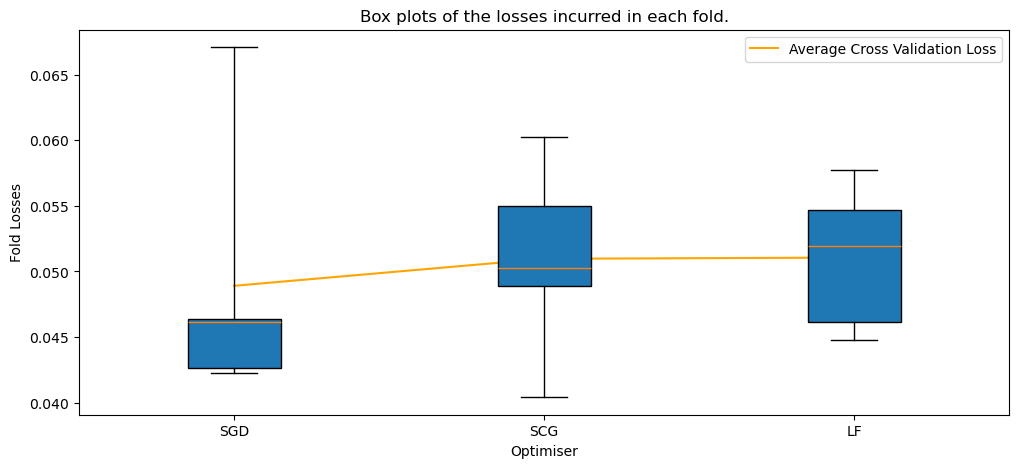

In [44]:
plt.figure(figsize=(12, 5))
plt.boxplot(function_2_fold_losses, vert=True, patch_artist=True, whis=[0, 100], zorder=2)
optimisers = ['SGD', 'SCG', 'LF']
plt.xticks(range(1, len(function_2_fold_losses)+1), list(map(str, optimisers)))
plt.plot(range(1, len(function_2_fold_losses)+1), [np.mean(x) for x in function_2_fold_losses], color='orange', zorder=1, label='Average Cross Validation Loss')
plt.title('Box plots of the losses incurred in each fold.')
plt.xlabel('Optimiser')
plt.ylabel('Fold Losses')
plt.legend()
plt.show()

In [45]:
f_stat, p_value = f_oneway(function_2_fold_losses[0], function_2_fold_losses[1], function_2_fold_losses[2])

print(f"F-statistic: {f_stat}")
print(f"P-value: {p_value}")

F-statistic: 0.11550157269869073
P-value: 0.8918976284506878


In [46]:
stat, p_value = stats.levene(*function_2_fold_losses)

print(f"Levene's test statistic: {stat}\nP-value: {p_value}")

Levene's test statistic: 0.07168199099361978
P-value: 0.9312223706641715


In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

mms = MinMaxScaler()
X_train = mms.fit_transform(X_train)
X_test = mms.transform(X_test)

y_train = mms.fit_transform(y_train)
y_test = mms.transform(y_test)

In [57]:
np.random.seed(123)
model = Sequential([
    layers.Input(shape=(2,)),
    layers.Dense(64, activation='tanh'),
    layers.Dense(1)
])
loss_fn = losses.MeanSquaredError()
model, train_losses, val_losses, total_time = train_model_SGD(model, 
                                              loss_fn, 
                                              X_train, 
                                              y_train, 
                                              learning_rate=0.01, 
                                              momentum=0.99, 
                                              X_val=X_test, 
                                              y_val=y_test,
                                              verbose=2)

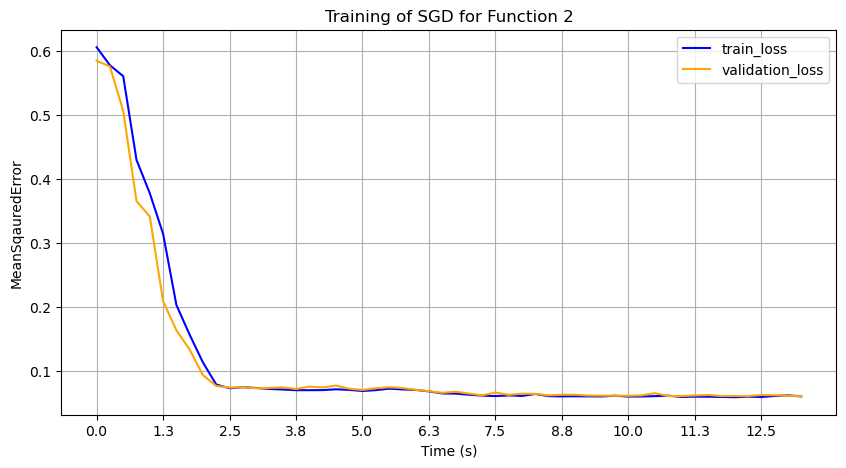

In [59]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, color='blue', label='train_loss')
plt.plot(val_losses, color='orange', label='validation_loss')
plt.xlabel('Time (s)')
plt.xticks(np.arange(0, len(train_losses), 5), np.round(np.arange(0, len(train_losses), 5) * total_time / len(train_losses), 1))
plt.ylabel('MeanSqauredError')
plt.title('Training of SGD for Function 2')
plt.grid()
plt.legend()
plt.show()

In [60]:
total_time

13.506307125091553

In [61]:
np.random.seed(123)
model = Sequential([
    layers.Input(shape=(2,)),
    layers.Dense(64, activation='tanh'),
    layers.Dense(1)
])
loss_fn = losses.MeanSquaredError()
model, train_losses, val_losses, total_time = train_model_SCG(
    model, 
    loss_fn, 
    X_train, 
    y_train, 
    X_val=X_test, 
    y_val=y_test,
    epochs=500,
    verbose=2)

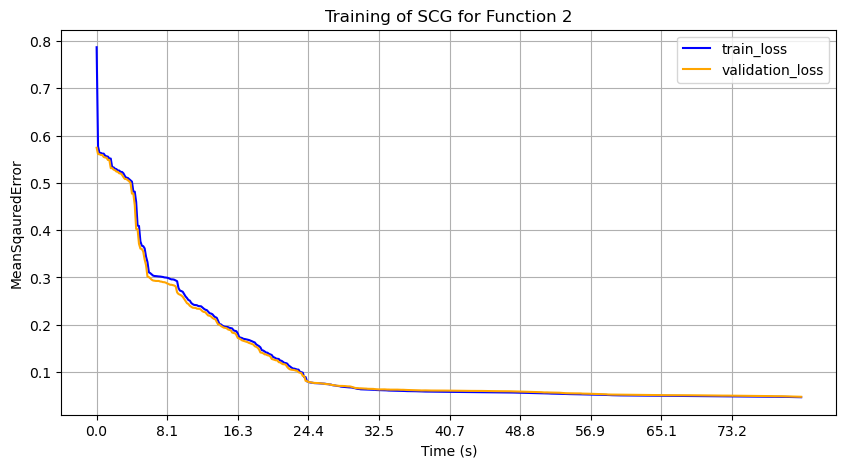

In [62]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, color='blue', label='train_loss')
plt.plot(val_losses, color='orange', label='validation_loss')
plt.xlabel('Time (s)')
plt.xticks(np.arange(0, len(train_losses), 50), np.round(np.arange(0, len(train_losses), 50) * total_time / len(train_losses), 1))
plt.ylabel('MeanSqauredError')
plt.title('Training of SCG for Function 2')
plt.grid()
plt.legend()
plt.show()

In [63]:
total_time

81.34811782836914

In [64]:
np.random.seed(123)
model = Sequential([
    layers.Input(shape=(2,)),
    layers.Dense(64, activation='tanh'),
    layers.Dense(1)
])
loss_fn = losses.MeanSquaredError()
model, train_losses, val_losses, total_time = train_model_LF(model, 
        loss_fn, 
        X_train, 
        y_train,
        tri_t=0.5,
        delta=1,
        epsilon=1e-6,
        m=3,
        delta1=0.01,
        X_val=X_test, 
        y_val=y_test, 
        epochs=500,
        patience=50,
        verbose=2)

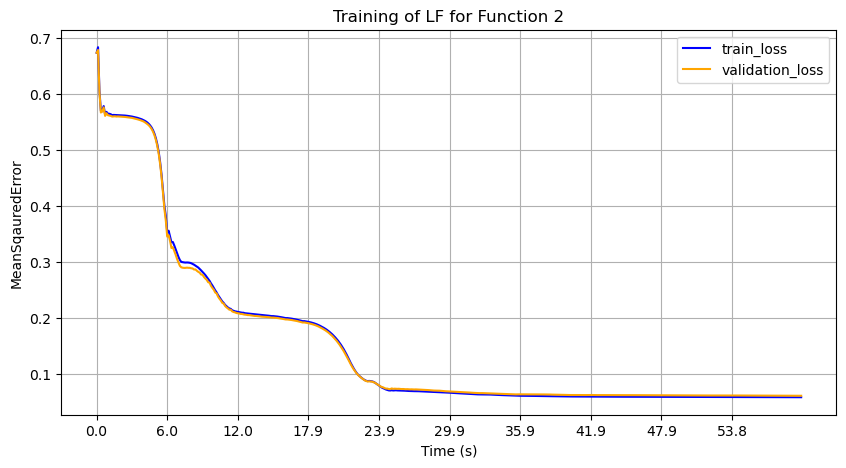

In [65]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, color='blue', label='train_loss')
plt.plot(val_losses, color='orange', label='validation_loss')
plt.xlabel('Time (s)')
plt.xticks(np.arange(0, len(train_losses), 50), np.round(np.arange(0, len(train_losses), 50) * total_time / len(train_losses), 1))
plt.ylabel('MeanSqauredError')
plt.title('Training of LF for Function 2')
plt.grid()
plt.legend()
plt.show()

In [66]:
total_time

59.815027475357056

# Function 3

In [48]:
df3 = pd.read_csv('Function3.csv', index_col=0)
df3.head()

,x,y,z
0,-9.287186,3.966279,11.129333
1,-1.575032,0.322606,-9.225558
2,-4.300286,-7.327547,11.822431
3,8.527971,-8.357167,10.489093
4,-3.181464,-9.689594,10.016285


In [49]:
X = df2.drop('z', axis=1).values
y = df2['z'].values

In [50]:
if not os.path.exists('function3_nhu_resutls.joblib'):

    np.random.seed(123)

    number_of_hidden_units = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
    best_learning_rates = []
    best_folds_losses = []
    best_averages = []

    for nhu in number_of_hidden_units:
        print('Processing number of hidden units', nhu)
        best_lr, best_ave, best_losses = learning_rate_cross_val(X, y, nhu)
        best_learning_rates.append(best_lr)
        best_folds_losses.append(best_losses)
        best_averages.append(best_ave)
    
    function3_nhu_resutls = {'best_learning_rates':best_learning_rates,
    'best_folds_losses':best_folds_losses,
    'best_averages':best_averages}
    joblib.dump(function3_nhu_resutls, 'function3_nhu_resutls.joblib')

else:
    best_learning_rates, best_folds_losses, best_averages = joblib.load('function3_nhu_resutls.joblib').values()

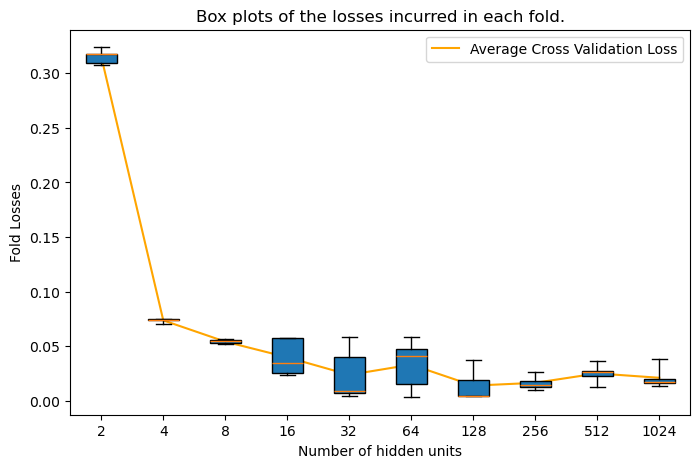

In [51]:
plt.figure(figsize=(8, 5))
plt.boxplot(best_folds_losses, vert=True, patch_artist=True, whis=[0, 100], zorder=2)
plt.xticks(range(1, len(number_of_hidden_units)+1), list(map(str, number_of_hidden_units)))
plt.plot(range(1, len(number_of_hidden_units)+1), best_averages, color='orange', zorder=1, label='Average Cross Validation Loss')
plt.title('Box plots of the losses incurred in each fold.')
plt.xlabel('Number of hidden units')
plt.ylabel('Fold Losses')
plt.legend()
plt.show()

From the boxplots clearly the number of hidden units 32, 64 and 128 performed the best. To see if there average cross validation loss is different a ANOVA test will be used.

In [52]:
f_stat, p_value = f_oneway(best_folds_losses[4], best_folds_losses[5], best_folds_losses[6])

print(f"F-statistic: {f_stat}")
print(f"P-value: {p_value}")

F-statistic: 1.0515799630069245
P-value: 0.37948000006227933


Since the p-value is not statistically significant, the hypothesis that the mean of the cross validation differing is not rejected. Therefore, the optimal number of hidden units chosen is 32, by the principle of Occam's Razor.

In [53]:
function_3_fold_losses = []

In [54]:
param_grid = {
    'momentum': [0.0, 0.5, 0.9, 0.99],
    'learning_rate': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]
}
mms = MinMaxScaler()

def _evaulate_splits(X, y, train_index, val_index, learning_rate, momentum):

    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    X_train = mms.fit_transform(X_train)
    X_val = mms.transform(X_val)

    y_train = mms.fit_transform(y_train)
    y_val = mms.transform(y_val)


    model = Sequential([
        layers.Input(shape=(2,)),
        layers.Dense(32, activation='tanh'),
        layers.Dense(1)
    ])
    loss_fn = losses.MeanSquaredError()
    model = train_model_SGD(
        model, 
        loss_fn, 
        X_train, 
        y_train, 
        learning_rate=learning_rate, 
        momentum=momentum, 
        X_val=X_val, 
        y_val=y_val,
        epochs=100,
        verbose=0)

    y_pred = model(X_val, training=False)
    val_loss = loss_fn(y_val, y_pred)
    return val_loss.numpy()

def hp_cross_val(X, y):
    kf = KFold(n_splits=5)
    best_learning_rate = None
    best_momentum = None
    best_fold_losses = None
    best_fold_averages = np.Inf

    for learning_rate in param_grid['learning_rate']:
        for momentum in param_grid['momentum']:
            print(f'Learning rate {learning_rate}')
            fold_losses = []

            fold_losses = Parallel(n_jobs=5)(delayed(_evaulate_splits)(
                X, y, train_index, val_index, learning_rate, momentum) for train_index, val_index in kf.split(X))
        
            avg_score = np.mean(fold_losses)
            print(avg_score)

            if avg_score < best_fold_averages:
                best_momentum = momentum
                best_learning_rate = learning_rate
                best_fold_averages = avg_score
                best_fold_losses = fold_losses
    
    return best_learning_rate, best_momentum, best_fold_losses, best_fold_averages


if not os.path.exists('function3_SGD_resutls.joblib'):

    np.random.seed(123)
    best_learning_rate, best_momentum, fold_scores, cross_val_score = hp_cross_val(X, y)
    
    function3_SGD_resutls = {
        'best_learning_rate': best_learning_rate,
        'best_momentum': best_momentum,
        'best_folds_losses': fold_scores,
        'best_cv_score':cross_val_score
    }
    joblib.dump(function3_SGD_resutls, 'function3_SGD_resutls.joblib')

else:
    best_learning_rate, best_momentum, best_folds_losses, best_cv_score = joblib.load('function3_SGD_resutls.joblib').values()
        

In [55]:
print(best_learning_rate, best_momentum, best_folds_losses, best_cv_score)

0.01 0.99 [0.0540271, 0.061687376, 0.049896408, 0.035507325, 0.0429394] 0.048811518


In [56]:
function_3_fold_losses.append(best_folds_losses)

In [57]:
# scaled conjugate
param_grid = {
    'None': [None]
}
mms = MinMaxScaler()

def _evaulate_splits(X, y, train_index, val_index):

    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    X_train = mms.fit_transform(X_train)
    X_val = mms.transform(X_val)

    y_train = mms.fit_transform(y_train)
    y_val = mms.transform(y_val)


    model = Sequential([
        layers.Input(shape=(2,)),
        layers.Dense(32, activation='tanh'),
        layers.Dense(1)
    ])
    loss_fn = losses.MeanSquaredError()
    model = train_model_SCG(
        model, 
        loss_fn, 
        X_train, 
        y_train,
        X_val=X_val, 
        y_val=y_val,
        epochs=500,
        verbose=0)

    y_pred = model(X_val, training=False)
    val_loss = loss_fn(y_val, y_pred)
    return val_loss.numpy()

def hp_cross_val(X, y):
    kf = KFold(n_splits=5)


    fold_losses = []

    fold_losses = Parallel(n_jobs=5)(delayed(_evaulate_splits)(
        X, y, train_index, val_index) for train_index, val_index in kf.split(X))

    avg_score = np.mean(fold_losses)
    print(avg_score)

    best_fold_averages = avg_score
    best_fold_losses = fold_losses
    
    return best_fold_losses, best_fold_averages


if not os.path.exists('function3_SCG_resutls.joblib'):

    np.random.seed(123)
    fold_scores, cross_val_score = hp_cross_val(X, y)
    
    function3_SCG_resutls = {
        'best_folds_losses': fold_scores,
        'best_cv_score':cross_val_score
    }
    joblib.dump(function3_SCG_resutls, 'function3_SCG_resutls.joblib')

else:
    best_folds_losses, best_cv_score = joblib.load('function3_SCG_resutls.joblib').values()
        

In [58]:
print(best_folds_losses, best_cv_score)

[0.055196766, 0.060587194, 0.060410883, 0.050959673, 0.058925197] 0.05721594


In [59]:
function_3_fold_losses.append(best_folds_losses)

In [60]:
# learp frog
param_grid = {
    'tri_t': [0.01, 0.1, 0.5],
    'm': [3],
    'delta1': [0.001, 0.01],
}
mms = MinMaxScaler()

def _evaulate_splits(X, y, train_index, val_index, tri_t, m, delta1):

    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    X_train = mms.fit_transform(X_train)
    X_val = mms.transform(X_val)

    y_train = mms.fit_transform(y_train)
    y_val = mms.transform(y_val)

    model = Sequential([
        layers.Input(shape=(2,)),
        layers.Dense(32, activation='tanh'),
        layers.Dense(1)
    ])
    loss_fn = losses.MeanSquaredError()
    model = train_model_LF(
        model, 
        loss_fn, 
        X_train, 
        y_train,
        tri_t=tri_t,
        delta=1,
        epsilon=1e-6,
        m=m,
        delta1=delta1,
        X_val=X_val, 
        y_val=y_val, 
        epochs=500,
        patience=50,
    )

    y_pred = model(X_val, training=False)
    val_loss = loss_fn(y_val, y_pred)
    return val_loss.numpy()

def hp_cross_val(X, y):
    kf = KFold(n_splits=5)
    best_tri_t = None
    best_delta1 = None
    best_m = None
    best_fold_losses = None
    best_fold_averages = np.Inf

    for tri_t in param_grid['tri_t']:
        for delta1 in param_grid['delta1']:
            for m in param_grid['m']:
                print(tri_t, delta1, m)
                fold_losses = []

                fold_losses = Parallel(n_jobs=5)(delayed(_evaulate_splits)(
                    X, y, train_index, val_index, tri_t, m, delta1) for train_index, val_index in kf.split(X))
            
                avg_score = np.mean(fold_losses)
                print(avg_score)

                if avg_score < best_fold_averages:
                    best_tri_t= tri_t
                    best_delta1 = delta1
                    best_m = m
                    best_fold_averages = avg_score
                    best_fold_losses = fold_losses
    
    return best_tri_t, best_delta1, best_m, best_fold_losses, best_fold_averages


if not os.path.exists('function3_LF_results.joblib'):

    np.random.seed(123)
    best_tri_t, best_delta1, best_m, fold_scores, cross_val_score = hp_cross_val(X, y)
    
    function3_LF_results = {
        'best_tri_t': best_tri_t,
        'best_delta1': best_delta1,
        'best_m': best_m,
        'best_folds_losses': fold_scores,
        'best_cv_score':cross_val_score
    }
    joblib.dump(function3_LF_results, 'function3_LF_results.joblib')

else:
    best_tri_t, best_delta1, best_m, best_folds_losses, best_cv_score = joblib.load('function3_LF_results.joblib').values()
        

In [61]:
print(best_tri_t, best_delta1, best_m, best_folds_losses, best_cv_score)

0.5 0.01 3 [0.054957476, 0.05822644, 0.05452385, 0.05134629, 0.057110365] 0.055232882


In [62]:
function_3_fold_losses.append(best_folds_losses)

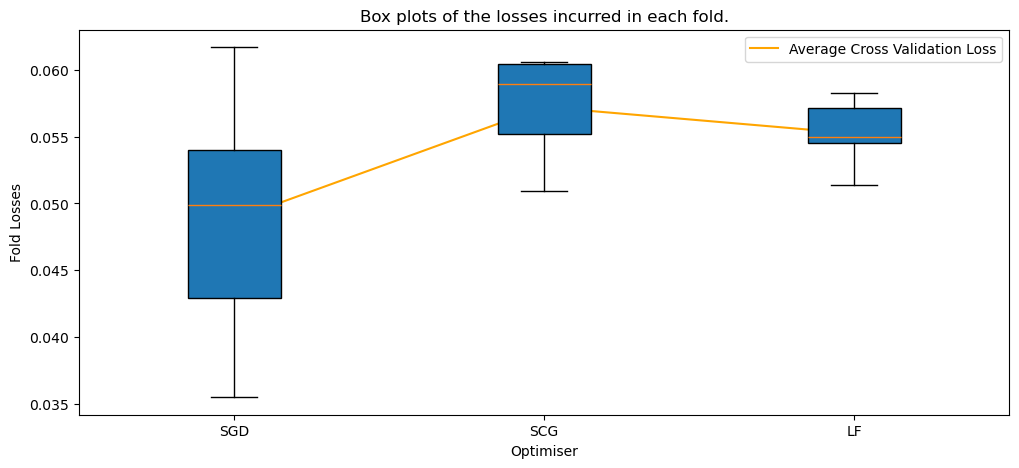

In [63]:
plt.figure(figsize=(12, 5))
plt.boxplot(function_3_fold_losses, vert=True, patch_artist=True, whis=[0, 100], zorder=2)
optimisers = ['SGD', 'SCG', 'LF']
plt.xticks(range(1, len(function_3_fold_losses)+1), list(map(str, optimisers)))
plt.plot(range(1, len(function_3_fold_losses)+1), [np.mean(x) for x in function_3_fold_losses], color='orange', zorder=1, label='Average Cross Validation Loss')
plt.title('Box plots of the losses incurred in each fold.')
plt.xlabel('Optimiser')
plt.ylabel('Fold Losses')
plt.legend()
plt.show()

In [64]:
f_stat, p_value = f_oneway(function_3_fold_losses[0], function_3_fold_losses[1], function_3_fold_losses[2])

print(f"F-statistic: {f_stat}")
print(f"P-value: {p_value}")

F-statistic: 2.3089337447941256
P-value: 0.14178677575273163


In [65]:
stat, p_value = stats.levene(*function_3_fold_losses)

print(f"Levene's test statistic: {stat}\nP-value: {p_value}")

Levene's test statistic: 2.857318601507874
P-value: 0.09662597785487168


In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

mms = MinMaxScaler()
X_train = mms.fit_transform(X_train)
X_test = mms.transform(X_test)

y_train = mms.fit_transform(y_train)
y_test = mms.transform(y_test)

In [86]:
np.random.seed(123)
model = Sequential([
    layers.Input(shape=(2,)),
    layers.Dense(32, activation='tanh'),
    layers.Dense(1)
])
loss_fn = losses.MeanSquaredError()
model, train_losses, val_losses, total_time = train_model_SGD(model, 
                                              loss_fn, 
                                              X_train, 
                                              y_train, 
                                              learning_rate=0.01, 
                                              momentum=0.99, 
                                              X_val=X_test, 
                                              y_val=y_test,
                                              verbose=2)

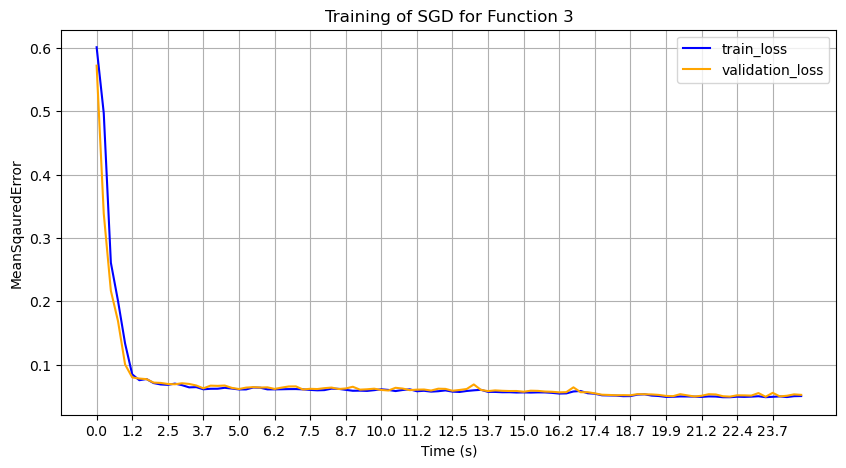

In [87]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, color='blue', label='train_loss')
plt.plot(val_losses, color='orange', label='validation_loss')
plt.xlabel('Time (s)')
plt.xticks(np.arange(0, len(train_losses), 5), np.round(np.arange(0, len(train_losses), 5) * total_time / len(train_losses), 1))
plt.ylabel('MeanSqauredError')
plt.title('Training of SGD for Function 3')
plt.grid()
plt.legend()
plt.show()

In [88]:
total_time

24.927238941192627

In [89]:
np.random.seed(123)
model = Sequential([
    layers.Input(shape=(2,)),
    layers.Dense(32, activation='tanh'),
    layers.Dense(1)
])
loss_fn = losses.MeanSquaredError()
model, train_losses, val_losses, total_time = train_model_SCG(
    model, 
    loss_fn, 
    X_train, 
    y_train, 
    X_val=X_test, 
    y_val=y_test, 
    epochs=500,
    verbose=2)

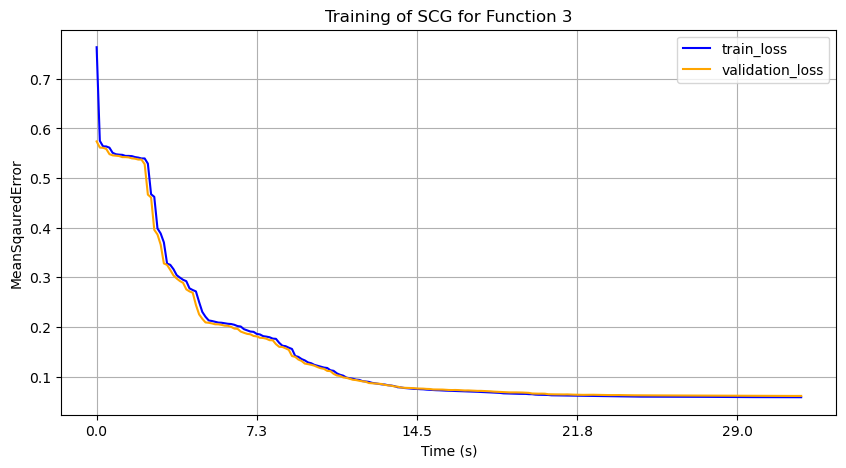

In [90]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, color='blue', label='train_loss')
plt.plot(val_losses, color='orange', label='validation_loss')
plt.xlabel('Time (s)')
plt.xticks(np.arange(0, len(train_losses), 50), np.round(np.arange(0, len(train_losses), 50) * total_time / len(train_losses), 1))
plt.ylabel('MeanSqauredError')
plt.title('Training of SCG for Function 3')
plt.grid()
plt.legend()
plt.show()

In [91]:
total_time

32.04714012145996

In [92]:
np.random.seed(123)
model = Sequential([
    layers.Input(shape=(2,)),
    layers.Dense(32, activation='tanh'),
    layers.Dense(1)
])
loss_fn = losses.MeanSquaredError()
model, train_losses, val_losses, total_time = train_model_LF(model, 
        loss_fn, 
        X_train, 
        y_train,
        tri_t=0.5,
        delta=1,
        epsilon=1e-6,
        m=3,
        delta1=0.01,
        X_val=X_test, 
        y_val=y_test, 
        epochs=500,
        patience=50,
        verbose=2)

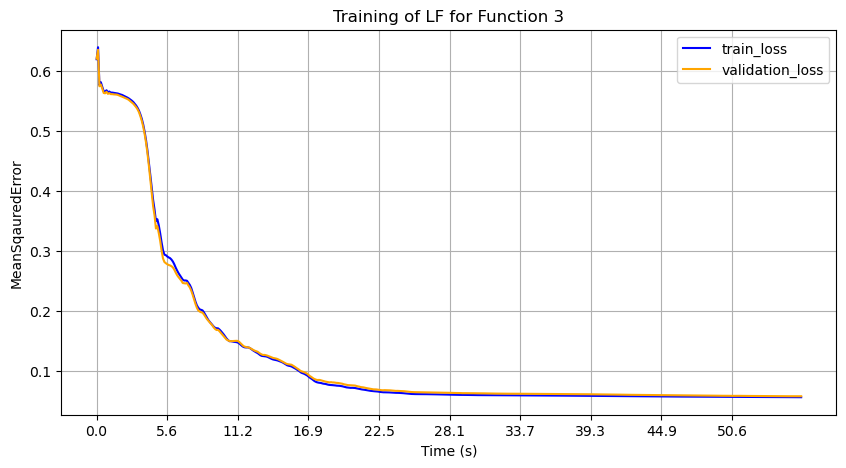

In [93]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, color='blue', label='train_loss')
plt.plot(val_losses, color='orange', label='validation_loss')
plt.xlabel('Time (s)')
plt.xticks(np.arange(0, len(train_losses), 50), np.round(np.arange(0, len(train_losses), 50) * total_time / len(train_losses), 1))
plt.ylabel('MeanSqauredError')
plt.title('Training of LF for Function 3')
plt.grid()
plt.legend()
plt.show()

In [155]:
total_time

58.9878146648407

# Function 4

In [67]:
df4 = pd.read_csv('Iris.csv', index_col=0)

In [68]:
df4.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [69]:
X = df4.drop('target', axis=1).values
y = df4['target'].values
num_classes = len(np.unique(y))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train_ohe = to_categorical(y_train, num_classes=num_classes)
y_test_ohe = to_categorical(y_test, num_classes=num_classes)

In [70]:
def _make_model(input_dim, hidden_units, learning_rate, num_classes) -> tf.keras.Model:
    model = Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(hidden_units, activation='tanh'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(loss=losses.CategoricalCrossentropy(), optimizer=optimizers.Adam(learning_rate=learning_rate))
    return model
adam_learning_rates = [0.0001, 0.001, 0.01, 0.1, 0.2]
mms = MinMaxScaler()

def _evaulate_splits(X, y, train_index, val_index, lr, number_of_hidden_units):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    X_train = mms.fit_transform(X_train)
    X_val = mms.transform(X_val)

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model = _make_model(4, number_of_hidden_units, lr, num_classes)
    model.fit(
        X_train, 
        y_train, 
        validation_data=(X_val, y_val),
        batch_size=64, 
        epochs=200,
        verbose=0,
        callbacks=early_stopping)
    
    val_loss = model.evaluate(X_val, y_val, verbose=0)
    return val_loss

def learning_rate_cross_val(X, y, number_of_hidden_units):
    kf = KFold(n_splits=5)
    best_lr = None
    best_fold_losses = None
    best_fold_averages = np.Inf

    for lr in adam_learning_rates:
        print(f'Learning rate {lr}')
        fold_losses = []

        fold_losses = Parallel(n_jobs=4)(delayed(_evaulate_splits)(
            X, y, train_index, val_index, lr, number_of_hidden_units) for train_index, val_index in kf.split(X))
    
        avg_score = np.mean(fold_losses)
        print(avg_score)
        if avg_score < best_fold_averages:
            best_fold_averages = avg_score
            best_fold_losses = fold_losses
            best_lr = lr
    
    return best_lr, best_fold_averages, best_fold_losses


# def estimate_number_of_hidden_units_regression(X, y):
number_of_hidden_units = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
if not os.path.exists('function4_nhu_resutls.joblib'):

    np.random.seed(123)
    best_learning_rates = []
    best_folds_losses = []
    best_averages = []

    for nhu in number_of_hidden_units:
        print('Processing number of hidden units', nhu)
        best_lr, best_ave, best_losses = learning_rate_cross_val(X_train, y_train_ohe, nhu)
        best_learning_rates.append(best_lr)
        best_folds_losses.append(best_losses)
        best_averages.append(best_ave)
    
    function4_nhu_resutls = {'best_learning_rates':best_learning_rates,
    'best_folds_losses':best_folds_losses,
    'best_averages':best_averages}
    joblib.dump(function4_nhu_resutls, 'function4_nhu_resutls.joblib')

else:
    best_learning_rates, best_folds_losses, best_averages = joblib.load('function4_nhu_resutls.joblib').values()
        

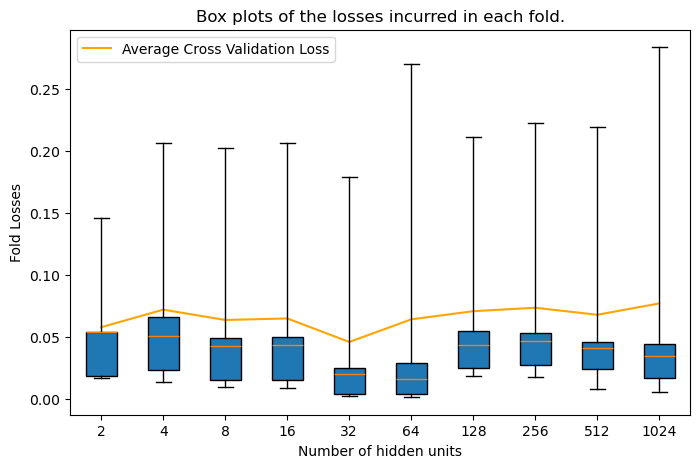

In [71]:
plt.figure(figsize=(8, 5))
plt.boxplot(best_folds_losses, vert=True, patch_artist=True, whis=[0, 100], zorder=2)
plt.xticks(range(1, len(number_of_hidden_units)+1), list(map(str, number_of_hidden_units)))
plt.plot(range(1, len(number_of_hidden_units)+1), best_averages, color='orange', zorder=1, label='Average Cross Validation Loss')
plt.title('Box plots of the losses incurred in each fold.')
plt.xlabel('Number of hidden units')
plt.ylabel('Fold Losses')
plt.legend()
plt.show()

From the box plot we can deduce that the means of cross validation losses of all the number of hidden units are similar. To test this hypothesis the ANOVA test will be used.

In [72]:
f_stat, p_value = f_oneway(best_folds_losses[0], best_folds_losses[1], best_folds_losses[2], best_folds_losses[3], best_folds_losses[4],
                           best_folds_losses[5], best_folds_losses[6], best_folds_losses[7], best_folds_losses[8], best_folds_losses[9])

print(f"F-statistic: {f_stat}")
print(f"P-value: {p_value}")

F-statistic: 0.05303926707415051
P-value: 0.9999654099768605


The p-value is extremely high and therefore the hypothesis is not rejected. The optimal number of hidden units is chosen to be 2, by the principle of Occam's Razor.

In [73]:
function_4_fold_losses = []

In [74]:
param_grid = {
    'momentum': [0.0, 0.5, 0.9, 0.99],
    'learning_rate': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]
}
mms = MinMaxScaler()

def _evaulate_splits(X, y, train_index, val_index, learning_rate, momentum):

    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    X_train = mms.fit_transform(X_train)
    X_val = mms.transform(X_val)

    model = Sequential([
        layers.Input(shape=(4,)),
        layers.Dense(2, activation='tanh'),
        layers.Dense(num_classes, activation='softmax')
    ])

    loss_fn = losses.CategoricalCrossentropy()
    model = train_model_SGD(
        model, 
        loss_fn, 
        X_train,
        y_train, 
        learning_rate=learning_rate, 
        momentum=momentum, 
        X_val=X_val, 
        y_val=y_val,
        epochs=100,
        patience=5,
        verbose=0)

    y_pred = model(X_val, training=False)
    val_loss = loss_fn(y_val, y_pred)
    return val_loss.numpy()

def hp_cross_val(X, y):
    kf = KFold(n_splits=5)
    best_learning_rate = None
    best_momentum = None
    best_fold_losses = None
    best_fold_averages = np.Inf

    for learning_rate in param_grid['learning_rate']:
        for momentum in param_grid['momentum']:
            print(f'Learning rate {learning_rate}')
            fold_losses = []

            fold_losses = Parallel(n_jobs=5)(delayed(_evaulate_splits)(
                X, y, train_index, val_index, learning_rate, momentum) for train_index, val_index in kf.split(X))
        
            avg_score = np.mean(fold_losses)
            print(avg_score)

            if avg_score < best_fold_averages:
                best_momentum = momentum
                best_learning_rate = learning_rate
                best_fold_averages = avg_score
                best_fold_losses = fold_losses
    
    return best_learning_rate, best_momentum, best_fold_losses, best_fold_averages


if not os.path.exists('function4_SGD_resutls.joblib'):

    np.random.seed(123)
    best_learning_rate, best_momentum, fold_scores, cross_val_score = hp_cross_val(X_train, y_train_ohe)
    
    function4_SGD_resutls = {
        'best_learning_rate': best_learning_rate,
        'best_momentum': best_momentum,
        'best_folds_losses': fold_scores,
        'best_cv_score':cross_val_score
    }
    joblib.dump(function4_SGD_resutls, 'function4_SGD_resutls.joblib')

else:
    best_learning_rate, best_momentum, best_folds_losses, best_cv_score = joblib.load('function4_SGD_resutls.joblib').values()
        

In [75]:
print(best_learning_rate, best_momentum, best_folds_losses, best_cv_score)

0.1 0.9 [0.084826104, 0.036430813, 0.26078907, 0.07415583, 0.056196988] 0.10247977


In [76]:
function_4_fold_losses.append(best_folds_losses)

In [77]:
# scaled conjugate
param_grid = {
    'None': [None]
}
mms = MinMaxScaler()

def _evaulate_splits(X, y, train_index, val_index):

    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    X_train = mms.fit_transform(X_train)
    X_val = mms.transform(X_val)

    model = Sequential([
        layers.Input(shape=(4,)),
        layers.Dense(2, activation='tanh'),
        layers.Dense(num_classes, activation='softmax')
    ])
    loss_fn = losses.CategoricalCrossentropy()
    model = train_model_SCG(
        model, 
        loss_fn, 
        X_train, 
        y_train,
        X_val=X_val, 
        y_val=y_val,
        epochs=500,
        patience=5,
        verbose=0)

    y_pred = model(X_val, training=False)
    val_loss = loss_fn(y_val, y_pred)
    return val_loss.numpy()

def hp_cross_val(X, y):
    kf = KFold(n_splits=5)


    fold_losses = []

    fold_losses = Parallel(n_jobs=5)(delayed(_evaulate_splits)(
        X, y, train_index, val_index) for train_index, val_index in kf.split(X))

    avg_score = np.mean(fold_losses)
    print(avg_score)

    best_fold_averages = avg_score
    best_fold_losses = fold_losses
    
    return best_fold_losses, best_fold_averages


if not os.path.exists('function4_SCG_resutls.joblib'):

    np.random.seed(123)
    fold_scores, cross_val_score = hp_cross_val(X_train, y_train_ohe)
    
    function4_SCG_resutls = {
        'best_folds_losses': fold_scores,
        'best_cv_score':cross_val_score
    }
    joblib.dump(function4_SCG_resutls, 'function4_SCG_resutls.joblib')

else:
    best_folds_losses, best_cv_score = joblib.load('function4_SCG_resutls.joblib').values()
        

In [78]:
function_4_fold_losses.append(best_folds_losses)

In [79]:
# learp frog
param_grid = {
    'tri_t': [0.01, 0.1, 0.5],
    'm': [3],
    'delta1': [0.001, 0.01],
}
mms = MinMaxScaler()

def _evaulate_splits(X, y, train_index, val_index, tri_t, m, delta1):

    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    X_train = mms.fit_transform(X_train)
    X_val = mms.transform(X_val)

    model = Sequential([
        layers.Input(shape=(4,)),
        layers.Dense(2, activation='tanh'),
        layers.Dense(num_classes, activation='softmax')
    ])
    loss_fn = losses.CategoricalCrossentropy()
    model = train_model_LF(
        model, 
        loss_fn, 
        X_train, 
        y_train,
        tri_t=tri_t,
        delta=1,
        epsilon=1e-6,
        m=m,
        delta1=delta1,
        X_val=X_val, 
        y_val=y_val, 
        epochs=500,
        patience=5,
    )

    y_pred = model(X_val, training=False)
    val_loss = loss_fn(y_val, y_pred)
    return val_loss.numpy()

def hp_cross_val(X, y):
    kf = KFold(n_splits=5)
    best_tri_t = None
    best_delta1 = None
    best_m = None
    best_fold_losses = None
    best_fold_averages = np.Inf

    for tri_t in param_grid['tri_t']:
        for delta1 in param_grid['delta1']:
            for m in param_grid['m']:
                print(tri_t, delta1, m)
                fold_losses = []

                fold_losses = Parallel(n_jobs=5)(delayed(_evaulate_splits)(
                    X, y, train_index, val_index, tri_t, m, delta1) for train_index, val_index in kf.split(X))
            
                avg_score = np.mean(fold_losses)
                print(avg_score)

                if avg_score < best_fold_averages:
                    best_tri_t= tri_t
                    best_delta1 = delta1
                    best_m = m
                    best_fold_averages = avg_score
                    best_fold_losses = fold_losses
    
    return best_tri_t, best_delta1, best_m, best_fold_losses, best_fold_averages


if not os.path.exists('function4_LF_results.joblib'):

    np.random.seed(123)
    best_tri_t, best_delta1, best_m, fold_scores, cross_val_score = hp_cross_val(X_train, y_train_ohe)
    
    function4_LF_results = {
        'best_tri_t': best_tri_t,
        'best_delta1': best_delta1,
        'best_m': best_m,
        'best_folds_losses': fold_scores,
        'best_cv_score':cross_val_score
    }
    joblib.dump(function4_LF_results, 'function4_LF_results.joblib')

else:
    best_tri_t, best_delta1, best_m, best_folds_losses, best_cv_score = joblib.load('function4_LF_results.joblib').values()
        

In [80]:
print(best_tri_t, best_delta1, best_m, best_folds_losses, best_cv_score)

0.5 0.01 3 [0.1770408, 0.04196352, 0.38278887, 0.05373362, 0.57499796] 0.24610496


In [81]:
function_4_fold_losses.append(best_folds_losses)

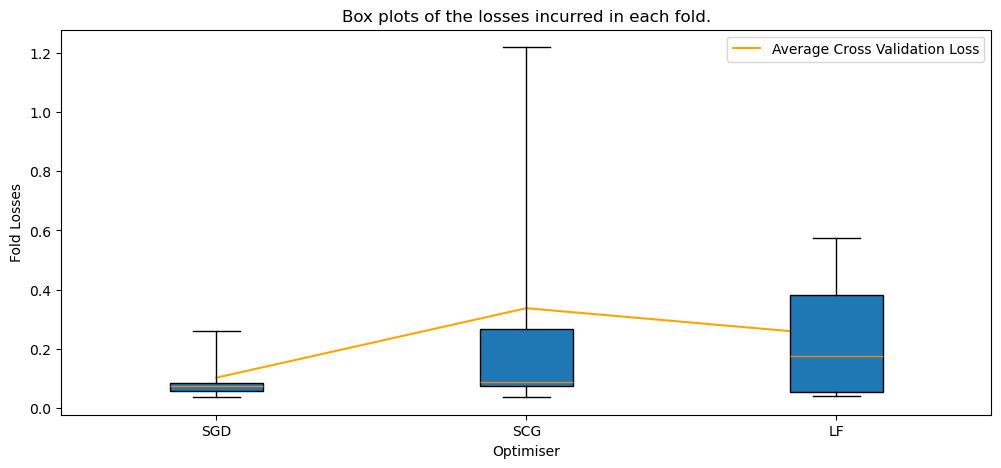

In [82]:
plt.figure(figsize=(12, 5))
plt.boxplot(function_4_fold_losses, vert=True, patch_artist=True, whis=[0, 100], zorder=2)
optimisers = ['SGD', 'SCG', 'LF']
plt.xticks(range(1, len(function_4_fold_losses)+1), list(map(str, optimisers)))
plt.plot(range(1, len(function_4_fold_losses)+1), [np.mean(x) for x in function_4_fold_losses], color='orange', zorder=1, label='Average Cross Validation Loss')
plt.title('Box plots of the losses incurred in each fold.')
plt.xlabel('Optimiser')
plt.ylabel('Fold Losses')
plt.legend()
plt.show()

In [83]:
f_stat, p_value = f_oneway(function_4_fold_losses[0], function_4_fold_losses[1], function_4_fold_losses[2])

print(f"F-statistic: {f_stat}")
print(f"P-value: {p_value}")

F-statistic: 0.6749079472672324
P-value: 0.5275162197573121


In [84]:
stat, p_value = stats.levene(*function_4_fold_losses)

print(f"Levene's test statistic: {stat}\nP-value: {p_value}")

Levene's test statistic: 0.7225475799051507
P-value: 0.5054802529348051


In [85]:
function_4_fold_losses

[[0.084826104, 0.036430813, 0.26078907, 0.07415583, 0.056196988],
 [0.0893761, 0.03805257, 0.26556316, 0.07437594, 1.219278],
 [0.1770408, 0.04196352, 0.38278887, 0.05373362, 0.57499796]]

In [105]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_train, y_train_ohe, test_size=0.2, random_state=42)

mms = MinMaxScaler()
X_train_ = mms.fit_transform(X_train_)
X_test_ = mms.transform(X_test_)

In [106]:
np.random.seed(123)
model = Sequential([
        layers.Input(shape=(4,)),
        layers.Dense(2, activation='tanh'),
        layers.Dense(num_classes, activation='softmax')
    ])
loss_fn = losses.CategoricalCrossentropy()
model_1, train_losses, val_losses, total_time = train_model_SGD(model, 
                                              loss_fn, 
                                              X_train_, 
                                              y_train_, 
                                              learning_rate=0.1, 
                                              momentum=0.9, 
                                              X_val=X_test_, 
                                              y_val=y_test_,
                                              verbose=2, patience=5)

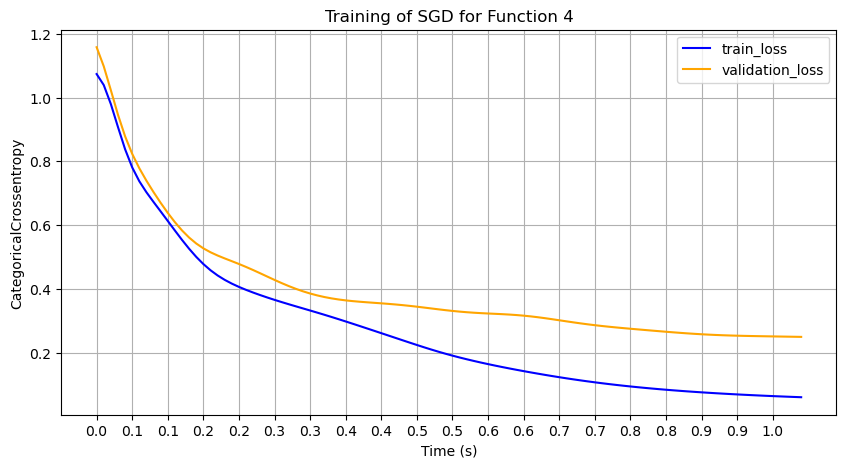

In [107]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, color='blue', label='train_loss')
plt.plot(val_losses, color='orange', label='validation_loss')
plt.xlabel('Time (s)')
plt.xticks(np.arange(0, len(train_losses), 5), np.round(np.arange(0, len(train_losses), 5) * total_time / len(train_losses), 1))
plt.ylabel('CategoricalCrossentropy')
plt.title('Training of SGD for Function 4')
plt.grid()
plt.legend()
plt.show()

In [108]:
np.random.seed(123)
model = Sequential([
        layers.Input(shape=(4,)),
        layers.Dense(2, activation='tanh'),
        layers.Dense(num_classes, activation='softmax')
    ])
loss_fn = losses.CategoricalCrossentropy()
model_2, train_losses, val_losses, total_time = train_model_SCG(
    model, 
    loss_fn, 
    X_train_, 
    y_train_, 
    X_val=X_test_, 
    y_val=y_test_, 
    epochs=500,
    patience=5,
    verbose=2)

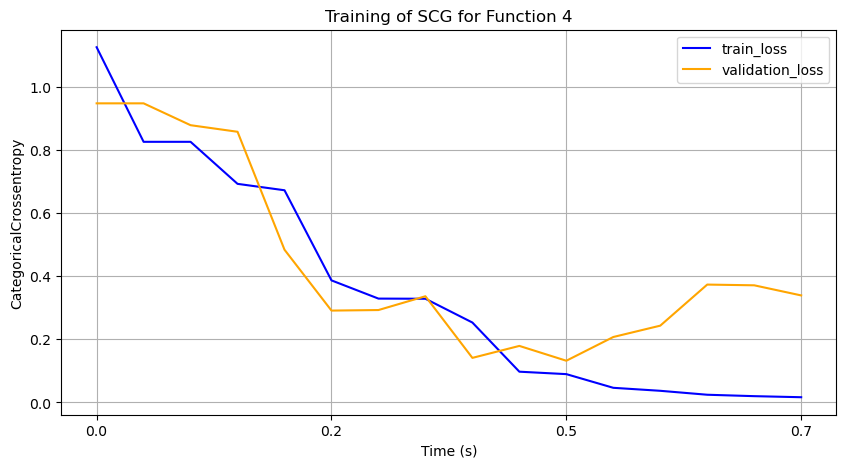

In [109]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, color='blue', label='train_loss')
plt.plot(val_losses, color='orange', label='validation_loss')
plt.xlabel('Time (s)')
plt.xticks(np.arange(0, len(train_losses), 5), np.round(np.arange(0, len(train_losses), 5) * total_time / len(train_losses), 1))
plt.ylabel('CategoricalCrossentropy')
plt.title('Training of SCG for Function 4')
plt.grid()
plt.legend()
plt.show()

In [110]:
np.random.seed(123)
model = Sequential([
        layers.Input(shape=(4,)),
        layers.Dense(2, activation='tanh'),
        layers.Dense(num_classes, activation='softmax')
    ])
loss_fn = losses.CategoricalCrossentropy()
model_3, train_losses, val_losses, total_time = train_model_LF(model, 
        loss_fn, 
        X_train_, 
        y_train_,
        tri_t=0.5,
        delta=1,
        epsilon=1e-6,
        m=3,
        delta1=0.01,
        X_val=X_test_, 
        y_val=y_test_, 
        epochs=500,
        patience=5,
        verbose=2)

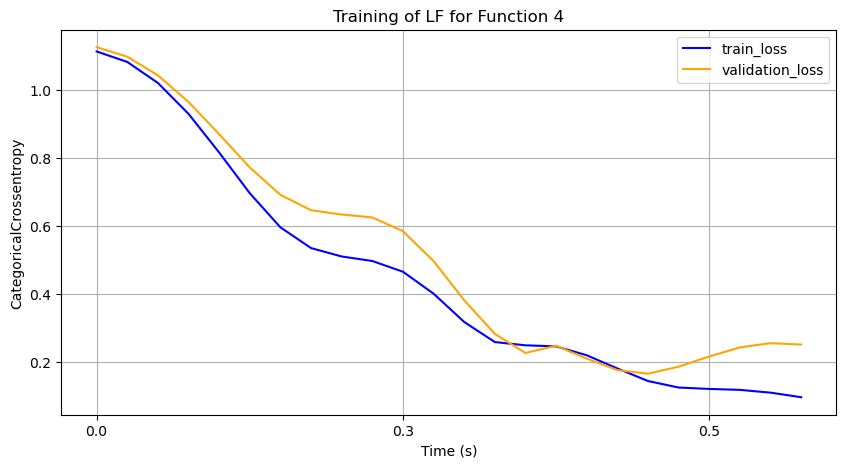

In [111]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, color='blue', label='train_loss')
plt.plot(val_losses, color='orange', label='validation_loss')
plt.xlabel('Time (s)')
plt.xticks(np.arange(0, len(train_losses), 10), np.round(np.arange(0, len(train_losses), 10) * total_time / len(train_losses), 1))
plt.ylabel('CategoricalCrossentropy')
plt.title('Training of LF for Function 4')
plt.grid()
plt.legend()
plt.show()

In [112]:
y_pred = np.argmax(model_1(X_test), axis=1)
print(f'Accuracy on test data using SGD: {np.mean(y_pred==y_test)}')

Accuracy on test data using SGD: 0.7


In [113]:
y_pred = np.argmax(model_2(X_test), axis=1)
print(f'Accuracy on test data using SCG: {np.mean(y_pred==y_test)}')

Accuracy on test data using SCG: 0.7


In [114]:
y_pred = np.argmax(model_3(X_test), axis=1)
print(f'Accuracy on test data using LF: {np.mean(y_pred==y_test)}')

Accuracy on test data using LF: 0.7


# Function 5

In [115]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

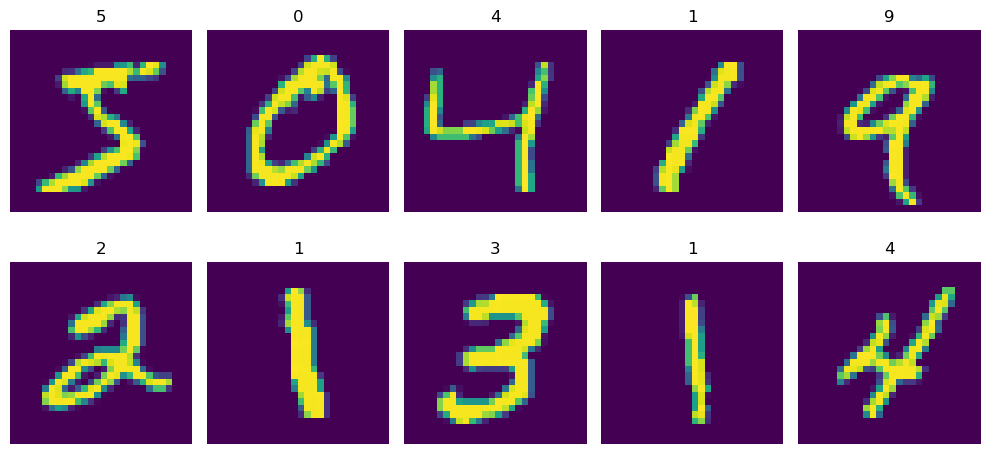

In [116]:
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_images[i])
    plt.title(train_labels[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [117]:
n_train = len(train_images)
n_test = len(test_images)
num_classes = len(np.unique(train_labels))

In [118]:
im_shape = train_images.shape[1:]

X_train = train_images.reshape((n_train, -1)) / 255.
X_test = test_images.reshape((n_test, -1)) / 255.

In [119]:
y_train = to_categorical(train_labels, num_classes=num_classes)
y_test = to_categorical(test_labels, num_classes=num_classes)

In [120]:
input_dim = X_train.shape[1]

In [121]:
num_classes

10

In [122]:
len(y_train), len(y_test)

(60000, 10000)

In [123]:
X_train[0].shape

(784,)

In [124]:
def _make_model(input_dim, hidden_units, learning_rate, num_classes) -> tf.keras.Model:
    model = Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(hidden_units, activation='tanh'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(loss=losses.CategoricalCrossentropy(), optimizer=optimizers.Adam(learning_rate=learning_rate))
    return model
adam_learning_rates = [0.0001, 0.001, 0.01, 0.1, 0.2]

def _evaulate_splits(X, y, train_index, val_index, lr, number_of_hidden_units):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model = _make_model(input_dim, number_of_hidden_units, lr, num_classes)
    model.fit(
        X_train, 
        y_train, 
        validation_data=(X_val, y_val),
        batch_size=256, 
        epochs=100,
        verbose=0,
        callbacks=early_stopping)
    
    val_loss = model.evaluate(X_val, y_val, verbose=0)
    return val_loss

def learning_rate_cross_val(X, y, number_of_hidden_units):
    kf = KFold(n_splits=5)
    best_lr = None
    best_fold_losses = None
    best_fold_averages = np.Inf

    for lr in adam_learning_rates:
        print(f'Learning rate {lr}')
        fold_losses = []

        fold_losses = Parallel(n_jobs=4)(delayed(_evaulate_splits)(
            X, y, train_index, val_index, lr, number_of_hidden_units) for train_index, val_index in kf.split(X))
    
        avg_score = np.mean(fold_losses)
        print(avg_score)
        if avg_score < best_fold_averages:
            best_fold_averages = avg_score
            best_fold_losses = fold_losses
            best_lr = lr
    
    return best_lr, best_fold_averages, best_fold_losses


# def estimate_number_of_hidden_units_regression(X, y):
if not os.path.exists('function5_nhu_resutls.joblib'):

    np.random.seed(123)

    number_of_hidden_units = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
    best_learning_rates = []
    best_folds_losses = []
    best_averages = []

    for nhu in number_of_hidden_units:
        print('Processing number of hidden units', nhu)
        best_lr, best_ave, best_losses = learning_rate_cross_val(X_train, y_train, nhu)
        best_learning_rates.append(best_lr)
        best_folds_losses.append(best_losses)
        best_averages.append(best_ave)
    
    function5_nhu_resutls = {'best_learning_rates':best_learning_rates,
    'best_folds_losses':best_folds_losses,
    'best_averages':best_averages}
    joblib.dump(function5_nhu_resutls, 'function5_nhu_resutls.joblib')

else:
    best_learning_rates, best_folds_losses, best_averages = joblib.load('function5_nhu_resutls.joblib').values()
        

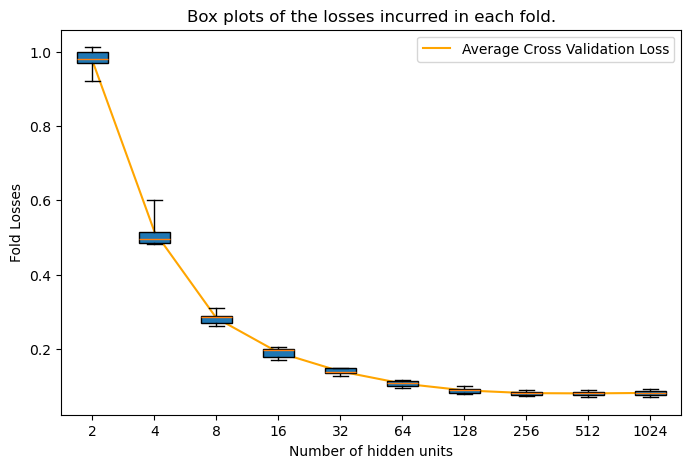

In [125]:
plt.figure(figsize=(8, 5))
plt.boxplot(best_folds_losses, vert=True, patch_artist=True, whis=[0, 100], zorder=2)
plt.xticks(range(1, len(number_of_hidden_units)+1), list(map(str, number_of_hidden_units)))
plt.plot(range(1, len(number_of_hidden_units)+1), best_averages, color='orange', zorder=1, label='Average Cross Validation Loss')
plt.title('Box plots of the losses incurred in each fold.')
plt.xlabel('Number of hidden units')
plt.ylabel('Fold Losses')
plt.legend()
plt.show()

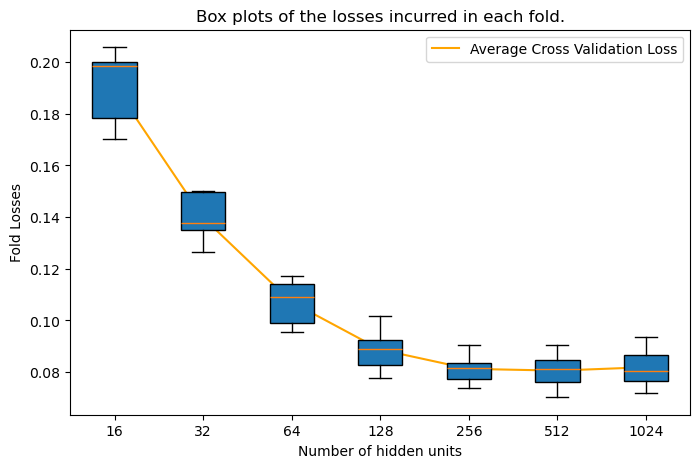

In [126]:
plt.figure(figsize=(8, 5))
plt.boxplot(best_folds_losses[3:], vert=True, patch_artist=True, whis=[0, 100], zorder=2)
plt.xticks(range(1, len(number_of_hidden_units)-2), list(map(str, number_of_hidden_units[3:])))
plt.plot(range(1, len(number_of_hidden_units)-2), best_averages[3:], color='orange', zorder=1, label='Average Cross Validation Loss')
plt.title('Box plots of the losses incurred in each fold.')
plt.xlabel('Number of hidden units')
plt.ylabel('Fold Losses')
plt.legend()
plt.show()

From the box plots it is evident that number of hidden units 128 and above has the lowest cross validation scores. To test if the number of hidden units of 128 and above have statistically different cross validation scores the anova test is used.

In [127]:
f_stat, p_value = f_oneway(best_folds_losses[6], best_folds_losses[7], best_folds_losses[8], best_folds_losses[9])

print(f"F-statistic: {f_stat}")
print(f"P-value: {p_value}")

F-statistic: 1.113257631263404
P-value: 0.3728841093805821


Since the p-value is larger than 0.05 and hence statistically significant we can deduce that the number of hidden units 128 and above doesnt have statistically significant different cross validation scores. Hence we choose the number of hidden units to be 128.

In [128]:
function_5_fold_losses = []

In [129]:
param_grid = {
    'momentum': [0.0, 0.5, 0.9, 0.99],
    'learning_rate': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]
}
mms = MinMaxScaler()

def _evaulate_splits(X, y, train_index, val_index, learning_rate, momentum):

    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model = Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='tanh'),
        layers.Dense(num_classes, activation='softmax')
    ])

    loss_fn = losses.CategoricalCrossentropy()
    model = train_model_SGD(
        model, 
        loss_fn, 
        X_train,
        y_train, 
        learning_rate=learning_rate, 
        momentum=momentum, 
        X_val=X_val, 
        y_val=y_val,
        epochs=100,
        verbose=0)

    y_pred = model(X_val, training=False)
    val_loss = loss_fn(y_val, y_pred)
    return val_loss.numpy()

def hp_cross_val(X, y):
    kf = KFold(n_splits=5)
    best_learning_rate = None
    best_momentum = None
    best_fold_losses = None
    best_fold_averages = np.Inf

    for learning_rate in param_grid['learning_rate']:
        for momentum in param_grid['momentum']:
            print(f'Learning rate {learning_rate}')
            fold_losses = []

            fold_losses = Parallel(n_jobs=5)(delayed(_evaulate_splits)(
                X, y, train_index, val_index, learning_rate, momentum) for train_index, val_index in kf.split(X))
        
            avg_score = np.mean(fold_losses)
            print(avg_score)

            if avg_score < best_fold_averages:
                best_momentum = momentum
                best_learning_rate = learning_rate
                best_fold_averages = avg_score
                best_fold_losses = fold_losses
    
    return best_learning_rate, best_momentum, best_fold_losses, best_fold_averages


if not os.path.exists('function5_SGD_resutls.joblib'):

    np.random.seed(123)
    best_learning_rate, best_momentum, fold_scores, cross_val_score = hp_cross_val(X_train, y_train)
    
    function5_SGD_resutls = {
        'best_learning_rate': best_learning_rate,
        'best_momentum': best_momentum,
        'best_folds_losses': fold_scores,
        'best_cv_score':cross_val_score
    }
    joblib.dump(function5_SGD_resutls, 'function5_SGD_resutls.joblib')

else:
    best_learning_rate, best_momentum, best_folds_losses, best_cv_score = joblib.load('function5_SGD_resutls.joblib').values()
        

In [130]:
print(best_learning_rate, best_momentum, best_folds_losses, best_cv_score)

0.05 0.9 [0.07288879, 0.09189801, 0.08706651, 0.09745993, 0.07943039] 0.08574873


In [131]:
function_5_fold_losses.append(best_folds_losses)

In [132]:
# scaled conjugate
param_grid = {
    'None': [None]
}
mms = MinMaxScaler()

def _evaulate_splits(X, y, train_index, val_index):

    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model = Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='tanh'),
        layers.Dense(num_classes, activation='softmax')
    ])
    loss_fn = losses.CategoricalCrossentropy()
    model = train_model_SCG(
        model, 
        loss_fn, 
        X_train, 
        y_train,
        X_val=X_val, 
        y_val=y_val,
        epochs=500,
        verbose=0)

    y_pred = model(X_val, training=False)
    val_loss = loss_fn(y_val, y_pred)
    return val_loss.numpy()

def hp_cross_val(X, y):
    kf = KFold(n_splits=5)


    fold_losses = []

    fold_losses = Parallel(n_jobs=5)(delayed(_evaulate_splits)(
        X, y, train_index, val_index) for train_index, val_index in kf.split(X))

    avg_score = np.mean(fold_losses)
    print(avg_score)

    best_fold_averages = avg_score
    best_fold_losses = fold_losses
    
    return best_fold_losses, best_fold_averages


if not os.path.exists('function5_SCG_resutls.joblib'):

    np.random.seed(123)
    fold_scores, cross_val_score = hp_cross_val(X_train, y_train)
    
    function5_SCG_resutls = {
        'best_folds_losses': fold_scores,
        'best_cv_score':cross_val_score
    }
    joblib.dump(function5_SCG_resutls, 'function5_SCG_resutls.joblib')

else:
    best_folds_losses, best_cv_score = joblib.load('function5_SCG_resutls.joblib').values()
        

In [133]:
print(best_folds_losses, best_cv_score)

[0.14728634, 0.11676824, 0.14384744, 0.13143031, 0.12899797] 0.13366607


In [134]:
function_5_fold_losses.append(best_folds_losses)

In [135]:
# learp frog
param_grid = {
    'tri_t': [0.01, 0.1, 0.5],
    'm': [3],
    'delta1': [0.001, 0.01],
}
mms = MinMaxScaler()

def _evaulate_splits(X, y, train_index, val_index, tri_t, m, delta1):

    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    X_train = mms.fit_transform(X_train)
    X_val = mms.transform(X_val)

    model = Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='tanh'),
        layers.Dense(num_classes, activation='softmax')
    ])
    loss_fn = losses.CategoricalCrossentropy()
    model = train_model_LF(
        model, 
        loss_fn, 
        X_train, 
        y_train,
        tri_t=tri_t,
        delta=1,
        epsilon=1e-6,
        m=m,
        delta1=delta1,
        X_val=X_val, 
        y_val=y_val, 
        epochs=500,
        patience=50,
    )

    y_pred = model(X_val, training=False)
    val_loss = loss_fn(y_val, y_pred)
    return val_loss.numpy()

def hp_cross_val(X, y):
    kf = KFold(n_splits=5)
    best_tri_t = None
    best_delta1 = None
    best_m = None
    best_fold_losses = None
    best_fold_averages = np.Inf

    for tri_t in param_grid['tri_t']:
        for delta1 in param_grid['delta1']:
            for m in param_grid['m']:
                print(tri_t, delta1, m)
                fold_losses = []

                fold_losses = Parallel(n_jobs=5)(delayed(_evaulate_splits)(
                    X, y, train_index, val_index, tri_t, m, delta1) for train_index, val_index in kf.split(X))
            
                avg_score = np.mean(fold_losses)
                print(avg_score)

                if avg_score < best_fold_averages:
                    best_tri_t= tri_t
                    best_delta1 = delta1
                    best_m = m
                    best_fold_averages = avg_score
                    best_fold_losses = fold_losses
    
    return best_tri_t, best_delta1, best_m, best_fold_losses, best_fold_averages


if not os.path.exists('function5_LF_results.joblib'):

    np.random.seed(123)
    best_tri_t, best_delta1, best_m, fold_scores, cross_val_score = hp_cross_val(X_train, y_train)
    
    function5_LF_results = {
        'best_tri_t': best_tri_t,
        'best_delta1': best_delta1,
        'best_m': best_m,
        'best_folds_losses': fold_scores,
        'best_cv_score':cross_val_score
    }
    joblib.dump(function5_LF_results, 'function5_LF_results.joblib')

else:
    best_tri_t, best_delta1, best_m, best_folds_losses, best_cv_score = joblib.load('function5_LF_results.joblib').values()
        

In [136]:
print(best_tri_t, best_delta1, best_m, best_folds_losses, best_cv_score)

0.1 0.001 3 [0.15858753, 0.22977816, 0.21258084, 0.20383108, 0.19167797] 0.19929112


In [137]:
function_5_fold_losses.append(best_folds_losses)

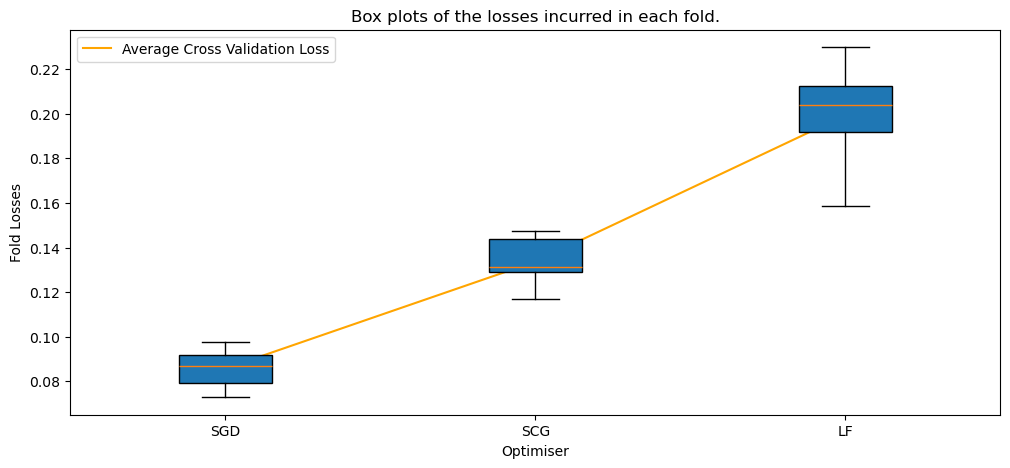

In [138]:
plt.figure(figsize=(12, 5))
plt.boxplot(function_5_fold_losses, vert=True, patch_artist=True, whis=[0, 100], zorder=2)
optimisers = ['SGD', 'SCG', 'LF']
plt.xticks(range(1, len(function_5_fold_losses)+1), list(map(str, optimisers)))
plt.plot(range(1, len(function_5_fold_losses)+1), [np.mean(x) for x in function_5_fold_losses], color='orange', zorder=1, label='Average Cross Validation Loss')
plt.title('Box plots of the losses incurred in each fold.')
plt.xlabel('Optimiser')
plt.ylabel('Fold Losses')
plt.legend()
plt.show()

In [139]:
f_stat, p_value = f_oneway(*function_5_fold_losses)

print(f"F-statistic: {f_stat}")
print(f"P-value: {p_value}")

F-statistic: 50.96719825869339
P-value: 1.3650807372759013e-06


In [140]:
stat, p_value = stats.levene(*function_5_fold_losses)

print(f"Levene's test statistic: {stat}\nP-value: {p_value}")

Levene's test statistic: 1.3381535168838175
P-value: 0.29880423162439124


In [141]:
f_stat, p_value = f_oneway(*function_5_fold_losses[:2])

print(f"F-statistic: {f_stat}")
print(f"P-value: {p_value}")

F-statistic: 46.69181948304246
P-value: 0.0001332507025374348


In [142]:
stat, p_value = stats.levene(*function_5_fold_losses[:2])

print(f"Levene's test statistic: {stat}\nP-value: {p_value}")

Levene's test statistic: 0.1675790457285526
P-value: 0.6930134715956484


In [143]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [144]:
np.random.seed(123)
model = Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='tanh'),
        layers.Dense(num_classes, activation='softmax')
    ])
loss_fn = losses.CategoricalCrossentropy()
model_1, train_losses, val_losses, total_time = train_model_SGD(model, 
                                              loss_fn, 
                                              X_train_, 
                                              y_train_, 
                                              learning_rate=0.05, 
                                              momentum=0.9, 
                                              X_val=X_test_, 
                                              y_val=y_test_,
                                              verbose=2)

KeyboardInterrupt: 

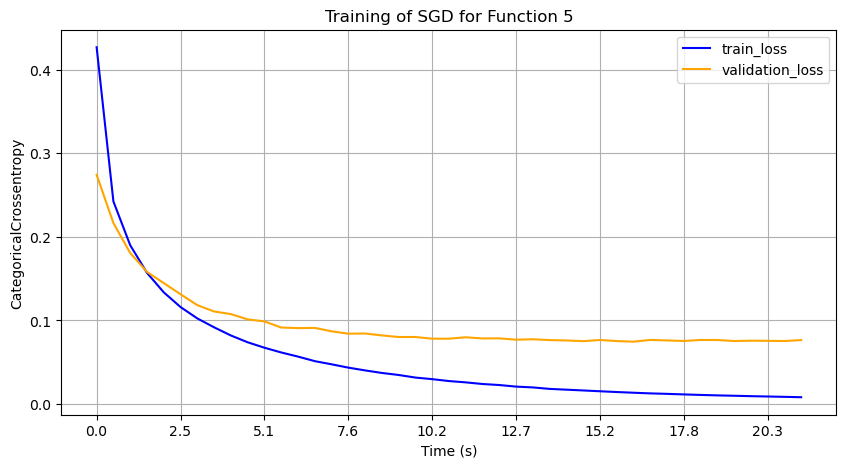

In [332]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, color='blue', label='train_loss')
plt.plot(val_losses, color='orange', label='validation_loss')
plt.xlabel('Time (s)')
plt.xticks(np.arange(0, len(train_losses), 5), np.round(np.arange(0, len(train_losses), 5) * total_time / len(train_losses), 1))
plt.ylabel('CategoricalCrossentropy')
plt.title('Training of SGD for Function 5')
plt.grid()
plt.legend()
plt.show()

In [333]:
np.random.seed(123)
model = Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='tanh'),
        layers.Dense(num_classes, activation='softmax')
    ])
loss_fn = losses.CategoricalCrossentropy()
model_2, train_losses, val_losses, total_time = train_model_SCG(
    model, 
    loss_fn, 
    X_train_, 
    y_train_, 
    X_val=X_test_, 
    y_val=y_test_, 
    epochs=500,
    verbose=2)

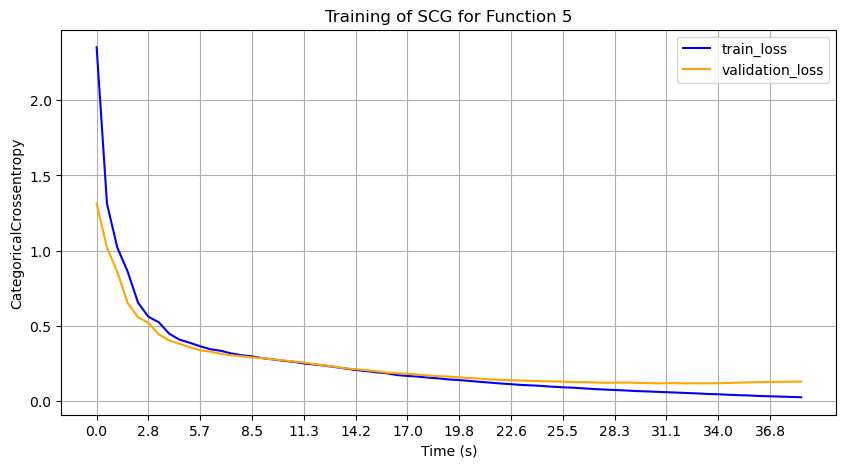

In [334]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, color='blue', label='train_loss')
plt.plot(val_losses, color='orange', label='validation_loss')
plt.xlabel('Time (s)')
plt.xticks(np.arange(0, len(train_losses), 5), np.round(np.arange(0, len(train_losses), 5) * total_time / len(train_losses), 1))
plt.ylabel('CategoricalCrossentropy')
plt.title('Training of SCG for Function 5')
plt.grid()
plt.legend()
plt.show()

In [335]:
np.random.seed(123)
model = Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='tanh'),
        layers.Dense(num_classes, activation='softmax')
    ])
loss_fn = losses.CategoricalCrossentropy()
model_3, train_losses, val_losses, total_time = train_model_LF(model, 
        loss_fn, 
        X_train_, 
        y_train_,
        tri_t=0.1,
        delta=1,
        epsilon=1e-6,
        m=3,
        delta1=0.001,
        X_val=X_test_, 
        y_val=y_test_, 
        epochs=500,
        patience=10,
        verbose=2)

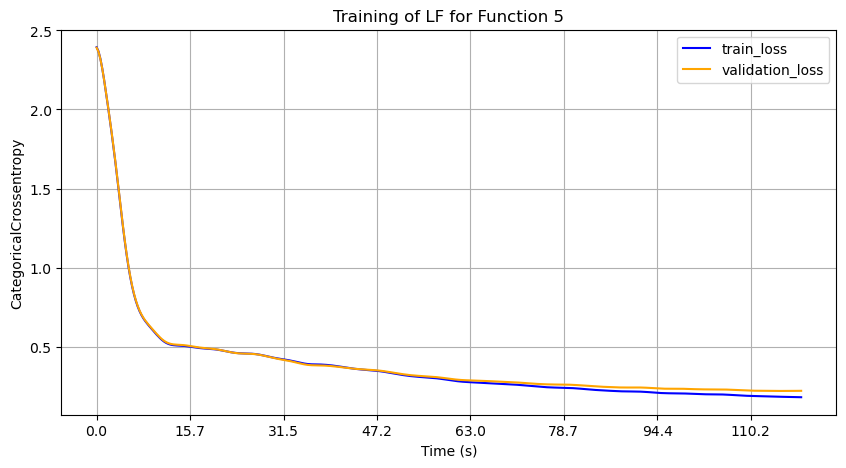

In [336]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, color='blue', label='train_loss')
plt.plot(val_losses, color='orange', label='validation_loss')
plt.xlabel('Time (s)')
plt.xticks(np.arange(0, len(train_losses), 50), np.round(np.arange(0, len(train_losses), 50) * total_time / len(train_losses), 1))
plt.ylabel('CategoricalCrossentropy')
plt.title('Training of LF for Function 5')
plt.grid()
plt.legend()
plt.show()

In [347]:
y_pred = model_1(X_test, training=False)
print(f'Accuracy on test data using SGD {np.mean(test_labels == np.argmax(y_pred, axis=1))}')

Accuracy on test data using SGD 0.9767


In [348]:
y_pred = model_2(X_test, training=False)
print(f'Accuracy on test data using SCG {np.mean(test_labels == np.argmax(y_pred, axis=1))}')

Accuracy on test data using SCG 0.9699


In [349]:
y_pred = model_3(X_test, training=False)
print(f'Accuracy on test data using LF {np.mean(test_labels == np.argmax(y_pred, axis=1))}')

Accuracy on test data using LF 0.9402


# Function 6

In [145]:
from tensorflow.keras.datasets import cifar10
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [146]:
train_images.shape, test_images.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

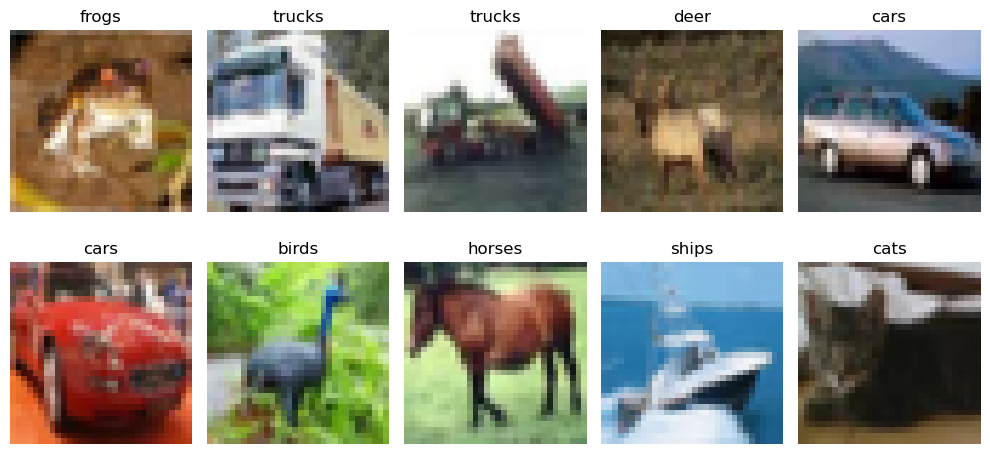

In [147]:
class_names = ['airplanes', 'cars', 'birds', 'cats', 'deer', 'dogs', 'frogs', 'horses', 'ships', 'trucks']
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_images[i])
    plt.title(class_names[train_labels[i][0]])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [148]:
n_train = len(train_images)
n_test = len(test_images)
num_classes = len(np.unique(train_labels.flatten()))

In [149]:
im_shape = train_images.shape[1:]

X_train = train_images.reshape((n_train, -1)) / 255.
X_test = test_images.reshape((n_test, -1)) / 255.

In [150]:
y_train = to_categorical(train_labels.flatten(), num_classes=num_classes)
y_test = to_categorical(test_labels.flatten(), num_classes=num_classes)

In [151]:
input_dim = X_train.shape[1]
input_dim

3072

In [152]:
for i in range(10):
    print(sum(train_labels==i))

[5000]
[5000]
[5000]
[5000]
[5000]
[5000]
[5000]
[5000]
[5000]
[5000]


In [153]:
num_classes

10

In [154]:
def _make_model(input_dim, hidden_units, learning_rate, num_classes) -> tf.keras.Model:
    model = Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(hidden_units, activation='tanh'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(loss=losses.CategoricalCrossentropy(), optimizer=optimizers.Adam(learning_rate=learning_rate))
    return model

In [155]:
adam_learning_rates = [0.0001, 0.001, 0.01, 0.1, 0.2]

def _evaulate_splits(X, y, train_index, val_index, lr, number_of_hidden_units):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model = _make_model(input_dim, number_of_hidden_units, lr, num_classes)
    model.fit(
        X_train, 
        y_train, 
        validation_data=(X_val, y_val),
        batch_size=256, 
        epochs=100,
        verbose=0,
        callbacks=early_stopping)
    
    val_loss = model.evaluate(X_val, y_val, verbose=0)
    return val_loss

def learning_rate_cross_val(X, y, number_of_hidden_units):
    kf = KFold(n_splits=5)
    best_lr = None
    best_fold_losses = None
    best_fold_averages = np.Inf

    for lr in adam_learning_rates:
        print(f'Learning rate {lr}')
        fold_losses = []

        fold_losses = Parallel(n_jobs=-1)(delayed(_evaulate_splits)(
            X, y, train_index, val_index, lr, number_of_hidden_units) for train_index, val_index in kf.split(X))
    
        avg_score = np.mean(fold_losses)
        print(avg_score)
        if avg_score < best_fold_averages:
            best_fold_averages = avg_score
            best_fold_losses = fold_losses
            best_lr = lr
    
    return best_lr, best_fold_averages, best_fold_losses


# def estimate_number_of_hidden_units_regression(X, y):
if not os.path.exists('function6_nhu_resutls.joblib'):

    np.random.seed(123)

    number_of_hidden_units = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
    best_learning_rates = []
    best_folds_losses = []
    best_averages = []

    for nhu in number_of_hidden_units:
        print('Processing number of hidden units', nhu)
        best_lr, best_ave, best_losses = learning_rate_cross_val(X_train, y_train, nhu)
        best_learning_rates.append(best_lr)
        best_folds_losses.append(best_losses)
        best_averages.append(best_ave)
    
    function6_nhu_resutls = {'best_learning_rates':best_learning_rates,
    'best_folds_losses':best_folds_losses,
    'best_averages':best_averages}
    joblib.dump(function6_nhu_resutls, 'function6_nhu_resutls.joblib')

else:
    best_learning_rates, best_folds_losses, best_averages = joblib.load('function6_nhu_resutls.joblib').values()
        

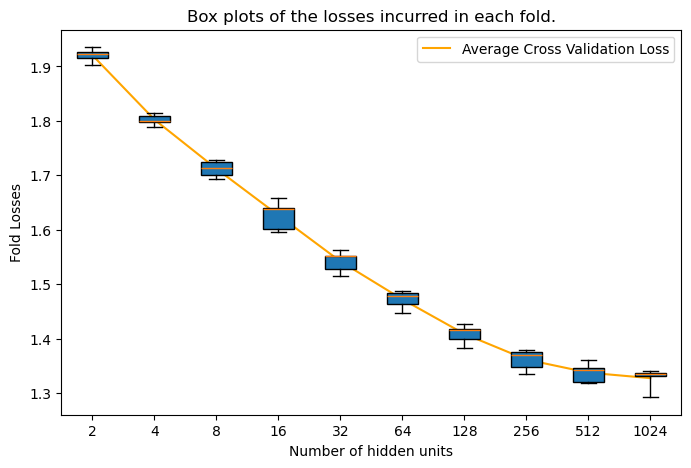

In [156]:
plt.figure(figsize=(8, 5))
plt.boxplot(best_folds_losses, vert=True, patch_artist=True, whis=[0, 100], zorder=2)
plt.xticks(range(1, len(number_of_hidden_units)+1), list(map(str, number_of_hidden_units)))
plt.plot(range(1, len(number_of_hidden_units)+1), best_averages, color='orange', zorder=1, label='Average Cross Validation Loss')
plt.title('Box plots of the losses incurred in each fold.')
plt.xlabel('Number of hidden units')
plt.ylabel('Fold Losses')
plt.legend()
plt.show()

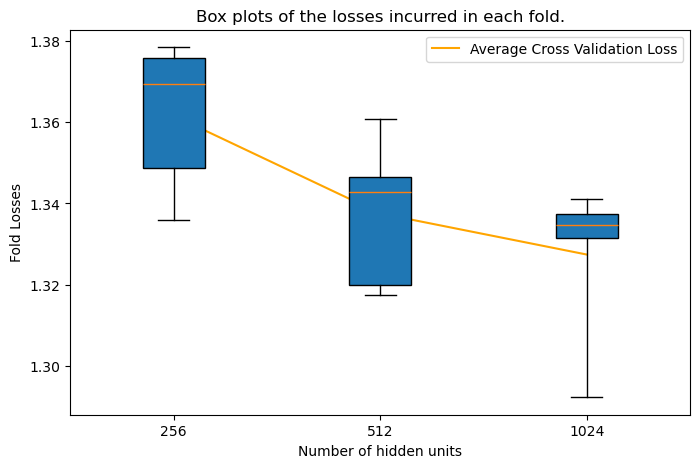

In [157]:
plt.figure(figsize=(8, 5))
plt.boxplot(best_folds_losses[-3:], vert=True, patch_artist=True, whis=[0, 100], zorder=2)
plt.xticks(range(1, len(number_of_hidden_units[-3:])+1), list(map(str, number_of_hidden_units[-3:])))
plt.plot(range(1, len(number_of_hidden_units[-3:])+1), best_averages[-3:], color='orange', zorder=1, label='Average Cross Validation Loss')
plt.title('Box plots of the losses incurred in each fold.')
plt.xlabel('Number of hidden units')
plt.ylabel('Fold Losses')
plt.legend()
plt.show()

From the box plots cross validation scores of 512 and 1024 hidden units are the lowest, to see whether number of hidden units 1024 have a lower cross validation score we perform an ANOVA test.

In [158]:
f_stat, p_value = f_oneway(best_folds_losses[8], best_folds_losses[9])

print(f"F-statistic: {f_stat}")
print(f"P-value: {p_value}")

F-statistic: 0.6941377967173381
P-value: 0.4289313237044433


The p-value is less than 0.05 thus there is not enough evidence to reject the hypothesis that there is a difference in cross validation scores. The chosen number of hidden units are thus 512 by the principle of ...

In [159]:
function_6_fold_losses = []

In [160]:
param_grid = {
    'momentum': [0.0, 0.5, 0.9, 0.99],
    'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1]
}
mms = MinMaxScaler()

def _evaulate_splits(X, y, train_index, val_index, learning_rate, momentum):

    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model = Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(512, activation='tanh'),
        layers.Dense(num_classes, activation='softmax')
    ])

    loss_fn = losses.CategoricalCrossentropy()
    model = train_model_SGD(
        model, 
        loss_fn, 
        X_train,
        y_train, 
        learning_rate=learning_rate, 
        momentum=momentum, 
        X_val=X_val, 
        y_val=y_val,
        epochs=100,
        batch_size=512,
        verbose=0)

    y_pred = model(X_val, training=False)
    val_loss = loss_fn(y_val, y_pred)
    return val_loss.numpy()

def hp_cross_val(X, y):
    kf = KFold(n_splits=5)
    best_learning_rate = None
    best_momentum = None
    best_fold_losses = None
    best_fold_averages = np.Inf

    for learning_rate in param_grid['learning_rate']:
        for momentum in param_grid['momentum']:
            print(f'Learning rate {learning_rate}')
            fold_losses = []

            fold_losses = Parallel(n_jobs=3)(delayed(_evaulate_splits)(
                X, y, train_index, val_index, learning_rate, momentum) for train_index, val_index in kf.split(X))
        
            avg_score = np.mean(fold_losses)
            print(avg_score)

            if avg_score < best_fold_averages:
                best_momentum = momentum
                best_learning_rate = learning_rate
                best_fold_averages = avg_score
                best_fold_losses = fold_losses
    
    return best_learning_rate, best_momentum, best_fold_losses, best_fold_averages


if not os.path.exists('function6_SGD_resutls.joblib'):

    np.random.seed(123)
    best_learning_rate, best_momentum, fold_scores, cross_val_score = hp_cross_val(X_train, y_train)
    
    function6_SGD_resutls = {
        'best_learning_rate': best_learning_rate,
        'best_momentum': best_momentum,
        'best_folds_losses': fold_scores,
        'best_cv_score':cross_val_score
    }
    joblib.dump(function6_SGD_resutls, 'function6_SGD_resutls.joblib')

else:
    best_learning_rate, best_momentum, best_folds_losses, best_cv_score = joblib.load('function6_SGD_resutls.joblib').values()
        

In [161]:
print(best_learning_rate, best_momentum, best_folds_losses, best_cv_score)

0.005 0.9 [1.3681223, 1.4028416, 1.3624649, 1.4060634, 1.389666] 1.3858316


In [162]:
function_6_fold_losses.append(best_folds_losses)

In [163]:
# scaled conjugate
param_grid = {
    'None': [None]
}
mms = MinMaxScaler()

def _evaulate_splits(X, y, train_index, val_index):

    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model = Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(512, activation='tanh'),
        layers.Dense(num_classes, activation='softmax')
    ])
    loss_fn = losses.CategoricalCrossentropy()
    model = train_model_SCG(
        model, 
        loss_fn, 
        X_train, 
        y_train,
        X_val=X_val, 
        y_val=y_val,
        epochs=500,
        verbose=0)

    y_pred = model(X_val, training=False)
    val_loss = loss_fn(y_val, y_pred)
    return val_loss.numpy()

def hp_cross_val(X, y):
    kf = KFold(n_splits=5)


    fold_losses = []

    fold_losses = Parallel(n_jobs=5)(delayed(_evaulate_splits)(
        X, y, train_index, val_index) for train_index, val_index in kf.split(X))

    avg_score = np.mean(fold_losses)
    print(avg_score)

    best_fold_averages = avg_score
    best_fold_losses = fold_losses
    
    return best_fold_losses, best_fold_averages


if not os.path.exists('function6_SCG_resutls.joblib'):

    np.random.seed(123)
    fold_scores, cross_val_score = hp_cross_val(X_train, y_train)
    
    function6_SCG_resutls = {
        'best_folds_losses': fold_scores,
        'best_cv_score':cross_val_score
    }
    joblib.dump(function6_SCG_resutls, 'function6_SCG_resutls.joblib')

else:
    best_folds_losses, best_cv_score = joblib.load('function6_SCG_resutls.joblib').values()
        

In [164]:
print(best_folds_losses, best_cv_score)

[1.3962073, 1.4030335, 1.3570565, 1.3947202, 1.394564] 1.3891163


In [165]:
function_6_fold_losses.append(best_folds_losses)

In [166]:
# learp frog
param_grid = {
    'tri_t': [0.01, 0.1, 0.5],
    'm': [3],
    'delta1': [0.001, 0.01],
}
mms = MinMaxScaler()

def _evaulate_splits(X, y, train_index, val_index, tri_t, m, delta1):

    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    X_train = mms.fit_transform(X_train)
    X_val = mms.transform(X_val)

    model = Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(512, activation='tanh'),
        layers.Dense(num_classes, activation='softmax')
    ])
    loss_fn = losses.CategoricalCrossentropy()
    model = train_model_LF(
        model, 
        loss_fn, 
        X_train, 
        y_train,
        tri_t=tri_t,
        delta=1,
        epsilon=1e-6,
        m=m,
        delta1=delta1,
        X_val=X_val, 
        y_val=y_val, 
        epochs=500,
        patience=50,
    )

    y_pred = model(X_val, training=False)
    val_loss = loss_fn(y_val, y_pred)
    return val_loss.numpy()

def hp_cross_val(X, y):
    kf = KFold(n_splits=5)
    best_tri_t = None
    best_delta1 = None
    best_m = None
    best_fold_losses = None
    best_fold_averages = np.Inf

    for tri_t in param_grid['tri_t']:
        for delta1 in param_grid['delta1']:
            for m in param_grid['m']:
                print(tri_t, delta1, m)
                fold_losses = []

                fold_losses = Parallel(n_jobs=5)(delayed(_evaulate_splits)(
                    X, y, train_index, val_index, tri_t, m, delta1) for train_index, val_index in kf.split(X))
            
                avg_score = np.mean(fold_losses)
                print(avg_score)

                if avg_score < best_fold_averages:
                    best_tri_t= tri_t
                    best_delta1 = delta1
                    best_m = m
                    best_fold_averages = avg_score
                    best_fold_losses = fold_losses
    
    return best_tri_t, best_delta1, best_m, best_fold_losses, best_fold_averages


if not os.path.exists('function6_LF_results.joblib'):

    np.random.seed(123)
    best_tri_t, best_delta1, best_m, fold_scores, cross_val_score = hp_cross_val(X_train, y_train)
    
    function6_LF_results = {
        'best_tri_t': best_tri_t,
        'best_delta1': best_delta1,
        'best_m': best_m,
        'best_folds_losses': fold_scores,
        'best_cv_score':cross_val_score
    }
    joblib.dump(function6_LF_results, 'function6_LF_results.joblib')

else:
    best_tri_t, best_delta1, best_m, best_folds_losses, best_cv_score = joblib.load('function6_LF_results.joblib').values()
        

In [167]:
print(best_tri_t, best_delta1, best_m, best_folds_losses, best_cv_score)

0.01 0.01 3 [1.5897014, 1.6364539, 1.5973016, 1.6203225, 1.6136845] 1.6114928


In [168]:
function_6_fold_losses.append(best_folds_losses)

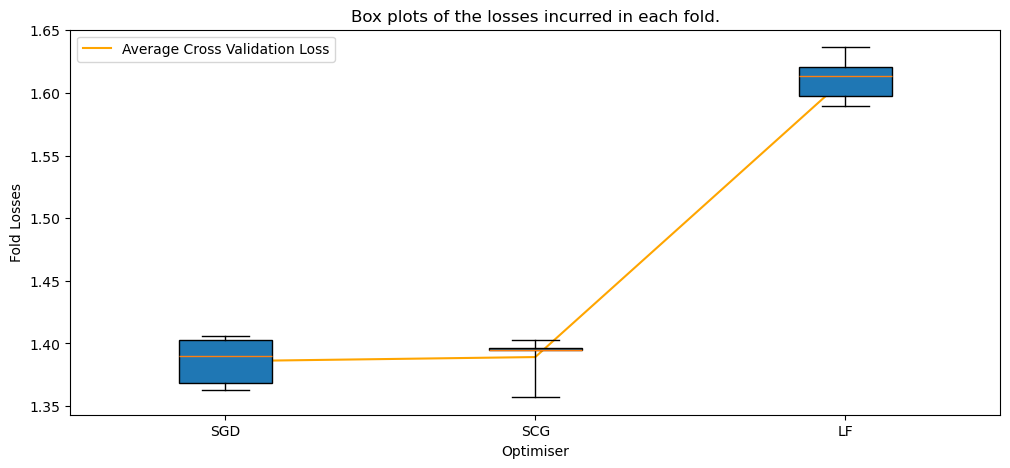

In [169]:
plt.figure(figsize=(12, 5))
plt.boxplot(function_6_fold_losses, vert=True, patch_artist=True, whis=[0, 100], zorder=2)
optimisers = ['SGD', 'SCG', 'LF']
plt.xticks(range(1, len(function_6_fold_losses)+1), list(map(str, optimisers)))
plt.plot(range(1, len(function_6_fold_losses)+1), [np.mean(x) for x in function_6_fold_losses], color='orange', zorder=1, label='Average Cross Validation Loss')
plt.title('Box plots of the losses incurred in each fold.')
plt.xlabel('Optimiser')
plt.ylabel('Fold Losses')
plt.legend()
plt.show()

In [170]:
f_stat, p_value = f_oneway(*function_6_fold_losses)

print(f"F-statistic: {f_stat}")
print(f"P-value: {p_value}")

F-statistic: 234.11035618992926
P-value: 2.434681469450818e-10


In [171]:
stat, p_value = stats.levene(*function_6_fold_losses)

print(f"Levene's test statistic: {stat}\nP-value: {p_value}")

Levene's test statistic: 0.3189941589664754
P-value: 0.7328579084427429


In [172]:
f_stat, p_value = f_oneway(*function_6_fold_losses[:2])

print(f"F-statistic: {f_stat}")
print(f"P-value: {p_value}")

F-statistic: 0.07425687606039334
P-value: 0.792138174080131


In [173]:
stat, p_value = stats.levene(*function_6_fold_losses[:2])

print(f"Levene's test statistic: {stat}\nP-value: {p_value}")

Levene's test statistic: 0.5177209894017438
P-value: 0.49229692976413025


In [174]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [175]:
np.random.seed(123)
model = Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(512, activation='tanh'),
        layers.Dense(num_classes, activation='softmax')
    ])
loss_fn = losses.CategoricalCrossentropy()
model_1, train_losses, val_losses, total_time = train_model_SGD(model, 
                                              loss_fn, 
                                              X_train_, 
                                              y_train_, 
                                              learning_rate=0.005, 
                                              momentum=0.9, 
                                              X_val=X_test_, 
                                              y_val=y_test_,
                                              verbose=2)

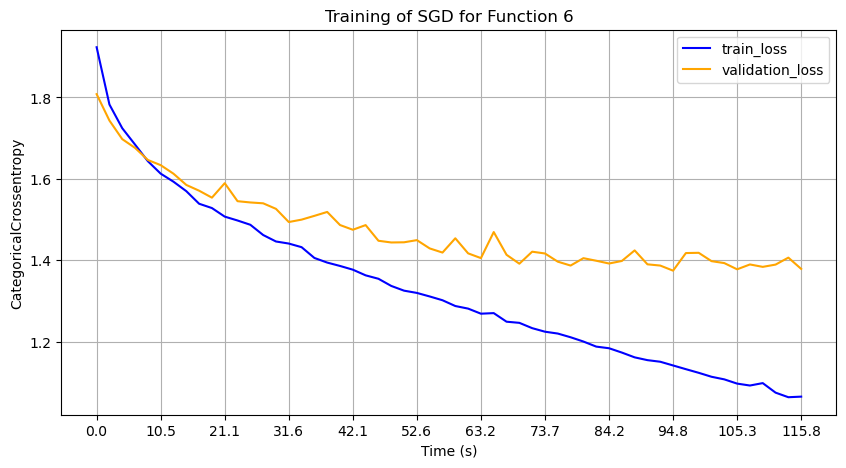

In [176]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, color='blue', label='train_loss')
plt.plot(val_losses, color='orange', label='validation_loss')
plt.xlabel('Time (s)')
plt.xticks(np.arange(0, len(train_losses), 5), np.round(np.arange(0, len(train_losses), 5) * total_time / len(train_losses), 1))
plt.ylabel('CategoricalCrossentropy')
plt.title('Training of SGD for Function 6')
plt.grid()
plt.legend()
plt.show()

In [177]:
np.random.seed(123)
model = Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(512, activation='tanh'),
        layers.Dense(num_classes, activation='softmax')
    ])
loss_fn = losses.CategoricalCrossentropy()
model_2, train_losses, val_losses, total_time = train_model_SCG(
    model, 
    loss_fn, 
    X_train_, 
    y_train_, 
    X_val=X_test_, 
    y_val=y_test_, 
    epochs=500,
    verbose=2)

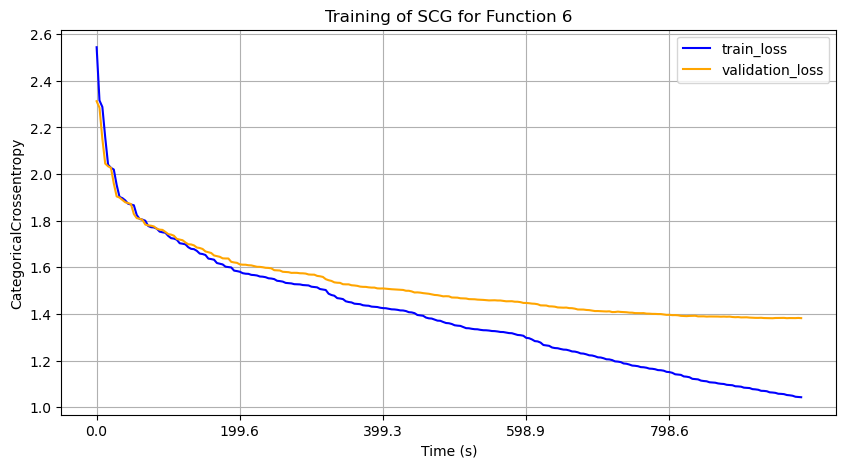

In [178]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, color='blue', label='train_loss')
plt.plot(val_losses, color='orange', label='validation_loss')
plt.xlabel('Time (s)')
plt.xticks(np.arange(0, len(train_losses), 50), np.round(np.arange(0, len(train_losses), 50) * total_time / len(train_losses), 1))
plt.ylabel('CategoricalCrossentropy')
plt.title('Training of SCG for Function 6')
plt.grid()
plt.legend()
plt.show()

In [179]:
np.random.seed(123)
model = Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(512, activation='tanh'),
        layers.Dense(num_classes, activation='softmax')
    ])
loss_fn = losses.CategoricalCrossentropy()
model_3, train_losses, val_losses, total_time = train_model_LF(model, 
        loss_fn, 
        X_train_, 
        y_train_,
        tri_t=0.01,
        delta=1,
        epsilon=1e-6,
        m=3,
        delta1=0.01,
        X_val=X_test_, 
        y_val=y_test_, 
        epochs=500,
        patience=50,
        verbose=2)

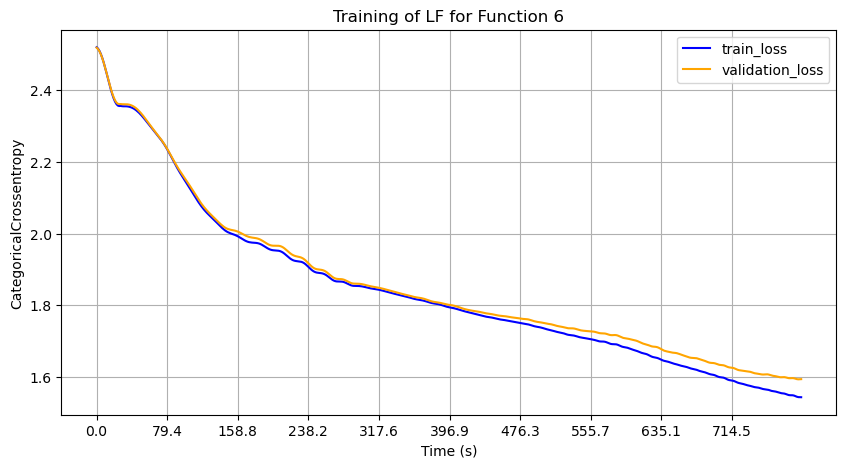

In [180]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, color='blue', label='train_loss')
plt.plot(val_losses, color='orange', label='validation_loss')
plt.xlabel('Time (s)')
plt.xticks(np.arange(0, len(train_losses), 50), np.round(np.arange(0, len(train_losses), 50) * total_time / len(train_losses), 1))
plt.ylabel('CategoricalCrossentropy')
plt.title('Training of LF for Function 6')
plt.grid()
plt.legend()
plt.show()

In [181]:
y_pred = model_1(X_test, training=False)
print(f'Accuracy on test data using SGD: {np.mean(test_labels.flatten() == np.argmax(y_pred, axis=1))}')

Accuracy on test data using SGD: 0.5205


In [182]:
y_pred = model_2(X_test, training=False)
print(f'Accuracy on test data using SCG: {np.mean(test_labels.flatten() == np.argmax(y_pred, axis=1))}')

Accuracy on test data using SCG: 0.5241


In [183]:
y_pred = model_3(X_test, training=False)
print(f'Accuracy on test data using LF: {np.mean(test_labels.flatten() == np.argmax(y_pred, axis=1))}')

Accuracy on test data using LF: 0.4458
